# Project Overview

In this project, we aim to analyze the profitability of DCA (Dollar-Cost Averaging) strategies used for meme coins in Telegram channels. The hypothesis is that these strategies, despite being used by bots, may influence the prices of low-cap coins due to their low liquidity.

The goal is to evaluate whether DCA strategies bring actual profits by observing historical signals, assessing how prices change over time, and eventually building a model to identify good signals. If successful, this can lead to the development of an automated trading bot.


# Goal of the Project

The primary goal of this project is to test whether DCA strategies applied to meme coins are profitable. Specifically, we aim to:

1. Validate the hypothesis that DCA bots influence meme coin prices.
2. Identify the key parameters that affect price fluctuations and how they relate to buy/sell signals.
3. Build a model that filters good trading signals, improving the efficiency of DCA strategies.
4. Develop an automated bot to trade meme coins based on this model.

Let's begin by understanding the steps taken for data collection and analysis.


# Data Structure and Format

The data collected contains the following key elements:

1. **Telegram Data:**
   - **message_id**: Unique ID for each message.
   - **date**: The date of the message.
   - **time**: The time the message was sent.
   - **timezone**: The timezone of the sender.
   - **position**: The position of the signal in the sequence.
   - **buy_amount**: The total amount of money allocated for buying or selling the token.
   - **sell_amount**: The portion of **buy_amount** to be spent at each interval in the DCA strategy.
   - **sell_interval**: The time interval at which **sell_amount** is spent, gradually accumulating to **buy_amount**.
   - **duration**: The duration for which the strategy is active.
   - **DCA_coin**: The coin being bought.
   - **OutCoin**: The coin used for selling.
   - **MC**: Market cap of the coin.
   - **Liq**: Liquidity of the coin.
   - **Price**: The price of the coin at the time of the signal.
   - **VI1h, V-5m, V-1h**: Various market volatility indicators.
   - **MEXC**: The data source (MEXC exchange).
   - **original_message**: The original text of the message.

2. **Price Data from MEXC:**
   - **open_price**: The opening price for the coin at the specified time period.
   - **close_price**: The closing price for the coin.
   - **max_price**: The highest price reached during the period.
   - **min_price**: The lowest price reached during the period.
   - **volume**: The trading volume during the period.
   - **interval_price_1 to interval_price_10**: The price at ten different intervals during the period to track price changes over time.

3. **Additional Considerations:**
   - **found_outcoin**: If "OutCoin" is not suitable for trading, we search for trading pairs between **DCA_coin** and USDC or USDT. These pairs theoretically should also influence the price.
   - **final_duration**: This refers to the period during which the price will be analyzed. If the initial duration is too short, it is increased to 15 minutes. If the original duration is longer than 15 minutes, it is kept unchanged.

Next, we'll begin the data analysis phase to check if DCA strategies yield profitable results.


## Data Analysis
In this section, we will analyze the data in three main steps:

### 1. Data Cleaning:
- Remove rows with missing values, especially those caused by incomplete MEXC data, parsing errors, or invalid entries from the interpreter.

### 2. Data Enrichment:
- Calculate additional parameters to better understand price dynamics:
  - **pct_change_close_price** – Percentage change from the signal to the closing price.
  - **pct_change_interval_price_1** to **pct_change_interval_price_10** – Price changes at each interval, considering whether the position was long or short.
  - **pct_change_max_price** – Maximum observed percentage increase after the signal (positive for long, negative for short).
  - **pct_change_min_price** – Maximum observed percentage decrease after the signal (negative for long, positive for short).

### 3. Data Analysis:
- Merge enriched Telegram and MEXC price data.
- Analyze price movements after DCA signals.
- Identify patterns in price fluctuations.
- Evaluate the effectiveness of the DCA strategy.
- Visualize results to highlight trends and anomalies.


# Data Loading: Importing and displaying the raw dataset

In [1]:
# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import random  # For generating random numbers
import seaborn as sns  # For advanced data visualization
from sklearn.preprocessing import StandardScaler  # For feature scaling
from scipy.stats import ttest_ind  # For statistical hypothesis testing
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, confusion_matrix, f1_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings


In [2]:
# Define the file path for the JSON file
file_path = r"data\processed_messages_2025-02-12_10-53-32.json"

# Read the JSON file into a DataFrame
df_raw = pd.read_json(file_path)

# Increase the number of displayed columns in the DataFrame
pd.set_option('display.max_columns', 12)

In [3]:
# Display the first few rows of the raw DataFrame
df_raw.head()

message_id       date      time  timezone position  buy_amount  ...  \
0       46527 2025-02-11  06:24:03         0    short    126110.0  ...   
1       46521 2025-02-11  05:57:27         0     long    232260.0  ...   
2       46516 2025-02-11  05:24:43         0    short     89850.0  ...   
3       46515 2025-02-11  05:23:29         0    short    149000.0  ...   
4       46508 2025-02-11  04:39:15         0     long     97630.0  ...   

   interval_price_5  interval_price_6  interval_price_7 interval_price_8  \
0          0.636180          0.635710          0.635640         0.634410   
1          0.637590          0.644990          0.644480         0.638300   
2               NaN               NaN               NaN              NaN   
3          0.011269          0.011269          0.011269         0.011269   
4          1.246270          1.249820          1.251490         1.248030   

  interval_price_9  interval_price_10  
0         0.633240           0.630500  
1         0.632600           0.631270  
2              NaN                NaN  
3         0.011269           0.011269  
4         1.252580           1.252300  

[5 rows x 36 columns]

In [4]:
# Display the last few rows of the raw DataFrame
df_raw.tail()

message_id       date      time  timezone position  buy_amount  ...  \
5095        1174 2025-01-08  11:54:19         0     long     78350.0  ...   
5096        1143 2025-01-08  11:52:31         0    short     74790.0  ...   
5097        1087 2025-01-08  11:28:19         0    short    171450.0  ...   
5098        1085 2025-01-08  11:27:43         0    short    353090.0  ...   
5099        1084 2025-01-08  11:26:57         0    short    353570.0  ...   

      interval_price_5  interval_price_6  interval_price_7 interval_price_8  \
5095               NaN               NaN               NaN              NaN   
5096               NaN               NaN               NaN              NaN   
5097               NaN               NaN               NaN              NaN   
5098               NaN               NaN               NaN              NaN   
5099               NaN               NaN               NaN              NaN   

     interval_price_9  interval_price_10  
5095              NaN                NaN  
5096              NaN                NaN  
5097              NaN                NaN  
5098              NaN                NaN  
5099              NaN                NaN  

[5 rows x 36 columns]

# Exploratory Data Analysis (EDA): Checking for Missing Values and Handling Nulls


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   message_id         5100 non-null   int64         
 1   date               5100 non-null   datetime64[ns]
 2   time               5100 non-null   object        
 3   timezone           5100 non-null   int64         
 4   position           5100 non-null   object        
 5   buy_amount         5100 non-null   float64       
 6   sell_amount        5100 non-null   float64       
 7   sell_interval      5100 non-null   int64         
 8   duration           5100 non-null   int64         
 9   DCA_coin           5097 non-null   object        
 10  OutCoin            5097 non-null   object        
 11  MC                 5100 non-null   float64       
 12  Liq                5099 non-null   float64       
 13  Price              5100 non-null   float64       
 14  VI1h    

In [6]:
df_raw.describe()

message_id                           date  timezone    buy_amount  \
count   5100.000000                           5100    5100.0  5.100000e+03   
mean   28110.870980  2025-01-21 17:06:04.235294208       0.0  3.390159e+05   
min     1084.000000            2025-01-08 00:00:00       0.0  7.001000e+04   
25%    24256.750000            2025-01-16 00:00:00       0.0  1.000300e+05   
50%    30579.000000            2025-01-20 00:00:00       0.0  1.635250e+05   
75%    34699.500000            2025-01-27 00:00:00       0.0  3.190275e+05   
max    46527.000000            2025-02-11 00:00:00       0.0  2.921000e+07   
std    10714.660061                            NaN       0.0  7.745362e+05   

        sell_amount  sell_interval  ...  interval_price_5  interval_price_6  \
count  5.100000e+03    5100.000000  ...      3.368000e+03      3.368000e+03   
mean   2.436959e+04      79.470588  ...      9.554203e+02      9.552482e+02   
min    1.500000e+03      60.000000  ...      1.820000e-07      1.818000e-07   
25%    4.097500e+03      60.000000  ...      9.989750e-02      1.000450e-01   
50%    8.655000e+03      60.000000  ...      4.410500e-01      4.401500e-01   
75%    2.000000e+04      60.000000  ...      1.320000e+00      1.320712e+00   
max    1.461000e+07    3600.000000  ...      1.054362e+05      1.054444e+05   
std    2.147708e+05     103.347170  ...      9.712869e+03      9.710961e+03   

       interval_price_7  interval_price_8  interval_price_9  interval_price_10  
count      3.368000e+03      3.368000e+03      3.368000e+03       3.368000e+03  
mean       9.548625e+02      9.547333e+02      9.547372e+02       9.545658e+02  
min        1.811000e-07      1.817000e-07      1.813000e-07       1.812000e-07  
25%        9.960000e-02      9.907425e-02      9.979000e-02       9.999750e-02  
50%        4.422000e-01      4.422000e-01      4.424150e-01       4.414200e-01  
75%        1.309578e+00      1.313473e+00      1.310770e+00       1.319943e+00  
max        1.054813e+05      1.054041e+05      1.053860e+05       1.053573e+05  
std        9.706784e+03      9.705307e+03      9.705300e+03       9.703447e+03  

[8 rows x 30 columns]

In [7]:
# Checking for Missing Values in the Dataset
df_raw.isnull().sum()


message_id              0
date                    0
time                    0
timezone                0
position                0
buy_amount              0
sell_amount             0
sell_interval           0
duration                0
DCA_coin                3
OutCoin                 3
MC                      0
Liq                     1
Price                   0
VI1h                 2601
V-5m                  316
V-1h                  203
MEXC                    0
original_message        0
open_price           1718
close_price          1718
max_price            1718
min_price            1718
volume               1718
found_outcoin         570
final_duration          0
interval_price_1     1732
interval_price_2     1732
interval_price_3     1732
interval_price_4     1732
interval_price_5     1732
interval_price_6     1732
interval_price_7     1732
interval_price_8     1732
interval_price_9     1732
interval_price_10    1732
dtype: int64

### Handling Missing Values

Upon analyzing the missing values in the dataset, the following actions will be taken:

1. **Remove the "VI1h" Column**: This column has 2601 missing values, which is a significant proportion of the data. It seems that the information for this column was not available in earlier messages, so it is safer to remove this column entirely to avoid unnecessary noise in the dataset.

2. **Remove Rows with Null Values**: We will remove rows where any of the critical columns, such as `DCA_coin`, `OutCoin`, `Liq`, and others related to price information (`open_price`, `close_price`, etc.), have missing values. These rows are essential for the analysis, and without complete price data or other critical values, they cannot be accurately analyzed. We prioritize data with information on `MEXC`, as it is a potential future trading platform for our analysis.

3. **Remove the "message_id" and "original_message" Columns**: These columns no longer provide valuable insights. The `message_id` is simply a unique identifier for each message and doesn't contribute to the analysis. Similarly, the `original_message` column contains the raw text of the messages, which is irrelevant to the analysis at this stage. Therefore, both columns will be removed.


In [8]:
df_cleaned = df_raw.drop(columns=['message_id', 'original_message', 'VI1h']).dropna().reset_index(drop=True)

In [9]:
df_cleaned.head()

date      time  timezone position  buy_amount  sell_amount  ...  \
0 2025-02-11  06:24:03         0    short    126110.0      15760.0  ...   
1 2025-02-11  05:57:27         0     long    232260.0       5530.0  ...   
2 2025-02-11  05:23:29         0    short    149000.0      14900.0  ...   
3 2025-02-11  04:39:15         0     long     97630.0       4880.0  ...   
4 2025-02-11  03:22:46         0     long    364020.0      72800.0  ...   

   interval_price_5  interval_price_6 interval_price_7 interval_price_8  \
0          0.636180          0.635710         0.635640         0.634410   
1          0.637590          0.644990         0.644480         0.638300   
2          0.011269          0.011269         0.011269         0.011269   
3          1.246270          1.249820         1.251490         1.248030   
4          0.011056          0.011056         0.011056         0.011056   

   interval_price_9  interval_price_10  
0          0.633240           0.630500  
1          0.632600           0.631270  
2          0.011269           0.011269  
3          1.252580           1.252300  
4          0.011056           0.011056  

[5 rows x 33 columns]

In [10]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               3285 non-null   datetime64[ns]
 1   time               3285 non-null   object        
 2   timezone           3285 non-null   int64         
 3   position           3285 non-null   object        
 4   buy_amount         3285 non-null   float64       
 5   sell_amount        3285 non-null   float64       
 6   sell_interval      3285 non-null   int64         
 7   duration           3285 non-null   int64         
 8   DCA_coin           3285 non-null   object        
 9   OutCoin            3285 non-null   object        
 10  MC                 3285 non-null   float64       
 11  Liq                3285 non-null   float64       
 12  Price              3285 non-null   float64       
 13  V-5m               3285 non-null   float64       
 14  V-1h    

In [11]:
# This function calculates the percentage change in prices relative to the opening price.
# It calculates the change for close price, interval prices, max price, and min price.
# Additionally, it adjusts the calculations for short positions by inverting the price changes.
# The function returns the updated DataFrame with the percentage change columns.

def calc_returns(df):
    # All columns for calculating percentage changes (close price and intervals)
    price_columns = ["close_price"] + [f"interval_price_{i}" for i in range(1, 11)]
    
    # Make a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # Calculate the percentage change for each price and its change
    for col in price_columns:
        # Calculate price change relative to open_price
        df[f"pct_change_{col}"] = ((df[col] - df["open_price"]) / df["open_price"]) * 100
        
        # For "short" positions, reverse the price change (for short positions, the price must drop for profit)
        df.loc[df["position"] == "short", f"pct_change_{col}"] *= -1

    # Calculate maximum profit and loss
    # For maximum profit and loss, we consider max_price and min_price
    df["pct_change_max_price"] = ((df["max_price"] - df["open_price"]) / df["open_price"]) * 100
    df["pct_change_min_price"] = ((df["min_price"] - df["open_price"]) / df["open_price"]) * 100

    # For short positions, reverse max and min price changes
    df.loc[df["position"] == "short", "pct_change_max_price"] *= -1
    df.loc[df["position"] == "short", "pct_change_min_price"] *= -1

    return df


In [12]:
df_processed = calc_returns(df_cleaned)

In [13]:
df_processed.head()

date      time  timezone position  buy_amount  sell_amount  ...  \
0 2025-02-11  06:24:03         0    short    126110.0      15760.0  ...   
1 2025-02-11  05:57:27         0     long    232260.0       5530.0  ...   
2 2025-02-11  05:23:29         0    short    149000.0      14900.0  ...   
3 2025-02-11  04:39:15         0     long     97630.0       4880.0  ...   
4 2025-02-11  03:22:46         0     long    364020.0      72800.0  ...   

   pct_change_interval_price_7  pct_change_interval_price_8  \
0                     1.204557                     1.395732   
1                     1.644981                     0.670294   
2                    -0.000000                    -0.000000   
3                     0.898947                     0.619991   
4                     0.000000                     0.000000   

  pct_change_interval_price_9 pct_change_interval_price_10  \
0                    1.577581                     2.003450   
1                   -0.228689                    -0.438451   
2                   -0.000000                    -0.000000   
3                    0.986826                     0.964252   
4                    0.000000                     0.000000   

   pct_change_max_price  pct_change_min_price  
0             -0.000000              2.003450  
1              2.047157             -1.140289  
2             -1.845772              1.419824  
3              1.073093             -0.156409  
4              0.434153              0.000000  

[5 rows x 46 columns]

In [14]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          3285 non-null   datetime64[ns]
 1   time                          3285 non-null   object        
 2   timezone                      3285 non-null   int64         
 3   position                      3285 non-null   object        
 4   buy_amount                    3285 non-null   float64       
 5   sell_amount                   3285 non-null   float64       
 6   sell_interval                 3285 non-null   int64         
 7   duration                      3285 non-null   int64         
 8   DCA_coin                      3285 non-null   object        
 9   OutCoin                       3285 non-null   object        
 10  MC                            3285 non-null   float64       
 11  Liq                           

In [15]:
df_processed.describe()

date  timezone    buy_amount   sell_amount  \
count                           3285    3285.0  3.285000e+03  3.285000e+03   
mean   2025-01-24 09:18:27.945205760       0.0  3.324023e+05  2.193964e+04   
min              2025-01-13 00:00:00       0.0  7.002000e+04  1.500000e+03   
25%              2025-01-19 00:00:00       0.0  1.012600e+05  4.260000e+03   
50%              2025-01-23 00:00:00       0.0  1.729600e+05  9.280000e+03   
75%              2025-01-30 00:00:00       0.0  3.347100e+05  2.173000e+04   
max              2025-02-11 00:00:00       0.0  1.409000e+07  1.090000e+06   
std                              NaN       0.0  5.879219e+05  5.155496e+04   

       sell_interval     duration  ...  pct_change_interval_price_7  \
count    3285.000000  3285.000000  ...                  3285.000000   
mean       81.223744    46.330289  ...                    -0.814287   
min        60.000000     2.000000  ...                 -1890.000000   
25%        60.000000    10.000000  ...                    -1.007980   
50%        60.000000    21.000000  ...                     0.081908   
75%        60.000000    60.000000  ...                     1.472784   
max      3600.000000  1500.000000  ...                   412.600000   
std       114.200446    78.081843  ...                    36.669051   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                  3285.000000                  3285.000000   
mean                     -0.995377                    -0.874322   
min                   -2305.700000                 -1680.000000   
25%                      -1.143699                    -1.303134   
50%                       0.091105                     0.068681   
75%                       1.608304                     1.783499   
max                     480.000000                   422.400000   
std                      44.134475                    34.548937   

       pct_change_interval_price_10  pct_change_max_price  \
count                   3285.000000           3285.000000   
mean                      -1.096556             -2.882736   
min                    -2341.400000          -2899.700000   
25%                       -1.361357             -1.621622   
50%                        0.096567              0.000000   
75%                        1.946421              1.340255   
max                      598.600000           2700.000000   
std                       46.053159             99.356413   

       pct_change_min_price  
count           3285.000000  
mean               0.699871  
min              -47.016359  
25%               -1.174699  
50%                0.043948  
75%                2.116112  
max               41.328175  
std                5.825961  

[8 rows x 41 columns]

### Statistical Analysis of df_processed: Identifying Anomalous Price Changes

After performing an initial analysis on the `df_processed` dataframe, we observed that some of the price changes appear to be completely anomalous. These extreme price fluctuations could indicate potential errors in the data or outliers that do not represent typical market behavior.

#### Key Observations:
- A significant number of changes in the percentage (`pct_change`) of the price for certain intervals are unusually high or low. These extreme values suggest that either:
  1. The market experienced extreme volatility, which may not be representative of normal trading conditions.
  2. There could be errors in the data collection, such as incorrect opening prices or early-stage trading effects, especially on exchanges like MEX where trading often starts later compared to DEX platforms.

Given these observations, it is important to examine these anomalous values closely to understand whether they represent genuine market behavior or errors in data collection. By identifying and investigating these anomalies, we can improve the accuracy of our analysis and ensure that the dataset used for modeling or decision-making is based on representative data.

In [16]:
# List of columns to check
columns_to_check = [
    'pct_change_close_price', 'pct_change_interval_price_1', 'pct_change_interval_price_2',
    'pct_change_interval_price_3', 'pct_change_interval_price_4', 'pct_change_interval_price_5',
    'pct_change_interval_price_6', 'pct_change_interval_price_7', 'pct_change_interval_price_8',
    'pct_change_interval_price_9', 'pct_change_interval_price_10', 'pct_change_max_price', 
    'pct_change_min_price'
]

# Filter rows where any value in the specified columns is either less than 100 or greater than 100
filtered_df = df_processed[df_processed[columns_to_check].lt(-100).any(axis=1) | df_processed[columns_to_check].gt(100).any(axis=1)]

# Display the filtered dataframe
filtered_df


date      time  timezone position  buy_amount  sell_amount  ...  \
59   2025-02-10  03:31:00         0     long    378380.0      37840.0  ...   
103  2025-02-09  15:16:33         0    short   1360000.0       2730.0  ...   
117  2025-02-09  05:37:19         0    short     79120.0       3960.0  ...   
118  2025-02-09  05:35:03         0    short    113100.0       7540.0  ...   
839  2025-01-30  03:08:01         0    short    361200.0      14450.0  ...   
840  2025-01-30  03:06:23         0    short    371920.0      18600.0  ...   
1598 2025-01-23  07:17:08         0     long    113330.0       1890.0  ...   
1601 2025-01-23  06:58:36         0    short     85450.0       1710.0  ...   
1602 2025-01-23  06:57:58         0    short     83950.0       1680.0  ...   
1607 2025-01-23  06:09:25         0    short   1550000.0       3110.0  ...   
1973 2025-01-21  09:03:49         0    short    494130.0       2470.0  ...   
2189 2025-01-20  02:15:13         0    short   1190000.0       3400.0  ...   
2660 2025-01-18  08:47:53         0    short    751340.0       3120.0  ...   
2716 2025-01-18  05:51:31         0    short    304830.0       1520.0  ...   
2727 2025-01-18  05:22:15         0     long    456680.0      15220.0  ...   
2728 2025-01-18  05:18:38         0     long    226080.0      22610.0  ...   
2730 2025-01-18  05:15:17         0    short     95070.0      47540.0  ...   
2731 2025-01-18  05:02:29         0    short    392030.0       6530.0  ...   

      pct_change_interval_price_7  pct_change_interval_price_8  \
59                     169.400000                   160.350000   
103                    -50.188007                   -87.017613   
117                    -50.628711                   -39.696123   
118                     -6.874798                    -3.526367   
839                   -230.166667                  -228.500000   
840                   -191.333333                  -177.500000   
1598                    57.882545                   141.449789   
1601                   -20.317460                   -23.222222   
1602                   -13.333333                   -19.047619   
1607                 -1890.000000                 -2305.700000   
1973                  -209.600000                  -237.600000   
2189                  -126.520000                  -114.360000   
2660                   -31.367713                   -36.621824   
2716                   -90.000000                  -142.919355   
2727                    18.411037                    21.550904   
2728                   412.600000                   480.000000   
2730                  -412.600000                  -480.000000   
2731                  -411.000000                  -473.900000   

     pct_change_interval_price_9 pct_change_interval_price_10  \
59                    178.250000                   173.600000   
103                  -100.841085                   -84.642786   
117                   -56.811037                   -57.160321   
118                   -18.553866                   -36.040116   
839                  -275.000000                  -275.000000   
840                  -184.166667                  -188.166667   
1598                  115.887723                   121.515193   
1601                  -42.031746                   -54.730159   
1602                  -45.587302                   -53.142857   
1607                -1680.000000                 -2341.400000   
1973                 -151.300000                  -186.700000   
2189                 -160.000000                  -158.000000   
2660                  -41.255605                   -59.828102   
2716                 -127.419355                  -105.709677   
2727                   35.585157                    37.274025   
2728                  422.400000                   598.600000   
2730                 -422.400000                  -598.600000   
2731                 -571.000000                  -580.000000   

      pct_change_max_price  pct_chang

In [17]:
# Список колонок, які потрібно вибрати
columns_to_select = ['position', 'DCA_coin', 'Price', 'open_price', 'close_price',
                     'interval_price_1', 'interval_price_2', 'interval_price_3', 
                     'interval_price_4', 'interval_price_5', 'interval_price_6', 
                     'interval_price_7', 'interval_price_8', 'interval_price_9', 'interval_price_10']

# Вибірка відповідних колонок з DataFrame
filtered_df_selected = filtered_df[columns_to_select]

# Виведення результату
filtered_df_selected


position    DCA_coin     Price  open_price  close_price  \
59       long         CAR   0.61080     0.20000      0.57200   
103     short   JAILSTOOL   0.19550     0.10106      0.17420   
117     short   JAILSTOOL   0.11020     0.05726      0.09522   
118     short   JAILSTOOL   0.11310     0.06182      0.12501   
839     short  JELLYJELLY   0.21550     0.06000      0.19000   
840     short  JELLYJELLY   0.22190     0.06000      0.23590   
1598     long        VINE   0.13780     0.07339      0.17900   
1601    short        VINE   0.17090     0.06300      0.13846   
1602    short        VINE   0.16790     0.06300      0.12500   
1607    short        VINE   0.16700     0.01000      0.29445   
1973    short     ZACHXBT   0.06756     0.01000      0.03001   
2189    short     MELANIA  10.31481     5.00000     11.40000   
2660    short       TRUMP  18.27584    13.38000     22.47900   
2716    short       TRUMP  11.00186     6.20000     11.80000   
2727     long       TRUMP   9.38265     4.20400      6.58700   
2728     long       TRUMP   9.29020     1.00000      4.80000   
2730    short       TRUMP   9.10693     1.00000     28.00000   
2731    short       TRUMP   7.71822     1.00000      6.97900   

      interval_price_1  ...  interval_price_5  interval_price_6  \
59             0.57210  ...           0.61700           0.54060   
103            0.10897  ...           0.16115           0.14282   
117            0.06180  ...           0.11678           0.10415   
118            0.05412  ...           0.06938           0.06609   
839            0.16580  ...           0.17050           0.18020   
840            0.16580  ...           0.17730           0.17640   
1598           0.07067  ...           0.08741           0.13846   
1601           0.06300  ...           0.07861           0.06999   
1602           0.06300  ...           0.07067           0.07262   
1607           0.04100  ...           0.13246           0.17779   
1973           0.05166  ...           0.05993           0.05522   
2189          40.00000  ...           8.02800           8.55000   
2660          13.48400  ...          15.77800          18.67200   
2716           6.71000  ...           9.07700           9.32800   
2727           4.41100  ...           4.43700           4.66500   
2728           4.10400  ...           4.52000           4.75600   
2730           4.10400  ...           4.52000           4.75600   
2731           4.10400  ...           4.41000           5.00000   

      interval_price_7  interval_price_8  interval_price_9  interval_price_10  
59             0.53880           0.52070           0.55650            0.54720  
103            0.15178           0.18900           0.20297            0.18660  
117            0.08625           0.07999           0.08979            0.08999  
118            0.06607           0.06400           0.07329            0.08410  
839            0.19810           0.19710           0.22500            0.22500  
840            0.17480           0.16650           0.17050            0.17290  
1598           0.11587           0.17720           0.15844            0.16257  
1601           0.07580           0.07763           0.08948            0.09748  
1602           0.07140           0.07500           0.09172            0.09648  
1607           0.19900           0.24057           0.17800            0.24414  
1973           0.03096           0.03376           0.02513            0.02867  
2189          11.32600          10.71800          13.00000           12.90000  
2660          17.57700          18.28000          18.90000           21.38500  
2716          11.78000          15.06100          14.10000           12.75400  
2727           4.97800           5.11000           5.70000            5.77100  
2728           5.12600           5.80000           5.22400            6.98600  
2730           5.12600           5.80000           5.22400            6.98600  
2731           5.11000           5.73900           6.71000            6.80

### Analysis of Price Anomalies Due to Token Listings on MEX Exchange

Upon further inspection of the anomalous data, we discovered that in 18 rows, there is a significant discrepancy between the price (`Price`) obtained from the message, the `open_price` from the exchange, and the `interval_price_1` (price after one minute from `open_price`). 

#### Key Observations:
- These discrepancies are particularly pronounced for tokens that were just listed on the MEX exchange. During this early stage, the price recorded on MEX is not representative of the price on decentralized exchanges (DEXs), where these tokens have been trading for a longer period.
- As a result, the data from these rows (where the `Price`, `open_price`, and `interval_price_1` values are abnormally different) are not suitable for analysis. These tokens were likely new listings, so the price data may not reflect the true market behavior at that moment.
- We have identified **18 rows** with such anomalies, which constitute a small fraction of the entire dataset (18 out of 3285 rows). Given the relatively small number of these rows, removing them will not significantly affect the overall dataset.

#### Solution:
To ensure that we work with more representative data, we will remove these 18 rows from the dataset. This will help improve the quality of the analysis by excluding erroneous data related to early trading on MEX and focusing on more reliable price movements.

We will proceed by filtering out these rows to retain only the data that better reflects the market behavior.

### Analyzing Positive Trades and Investment Simulation

In our analysis, we will apply the following methods for different dataframes to:

1. **Determine the number of positive trades** based on specific exit points for each interval. This helps in evaluating the success rate of trades across different time intervals.

2. **Simulate an investment** of $1000 where no more than 1% of the capital is invested in any single trade. The simulation runs through each price change interval, updating the capital after each trade.

The objective of the simulation is to assess whether the trading strategy is profitable or not based on the final capital after completing all the trades in each interval.

#### Investment Strategy Simulation:
- **Initial Capital**: $1000 (this amount is simulated for each trade in the dataframe).
- **Investment per Trade**: 1% of the current capital.
- **Result**: After running the simulation through all price changes in the specified interval, the final capital will be recorded, allowing us to compare how the capital grows or shrinks depending on the price changes over time.

By running this simulation for different intervals, we can analyze if the strategy leads to profitable outcomes or if there is a loss, helping in further refining the investment strategy.


In [18]:
# Видалення рядків з df_processed, що є в filtered_df
df_processed.drop(filtered_df.index, inplace=True)

# Оновлення індексації після видалення
df_processed.reset_index(drop=True, inplace=True)

# Перевірка результату
df_processed.head()


date      time  timezone position  buy_amount  sell_amount  ...  \
0 2025-02-11  06:24:03         0    short    126110.0      15760.0  ...   
1 2025-02-11  05:57:27         0     long    232260.0       5530.0  ...   
2 2025-02-11  05:23:29         0    short    149000.0      14900.0  ...   
3 2025-02-11  04:39:15         0     long     97630.0       4880.0  ...   
4 2025-02-11  03:22:46         0     long    364020.0      72800.0  ...   

   pct_change_interval_price_7  pct_change_interval_price_8  \
0                     1.204557                     1.395732   
1                     1.644981                     0.670294   
2                    -0.000000                    -0.000000   
3                     0.898947                     0.619991   
4                     0.000000                     0.000000   

  pct_change_interval_price_9 pct_change_interval_price_10  \
0                    1.577581                     2.003450   
1                   -0.228689                    -0.438451   
2                   -0.000000                    -0.000000   
3                    0.986826                     0.964252   
4                    0.000000                     0.000000   

   pct_change_max_price  pct_change_min_price  
0             -0.000000              2.003450  
1              2.047157             -1.140289  
2             -1.845772              1.419824  
3              1.073093             -0.156409  
4              0.434153              0.000000  

[5 rows x 46 columns]

In [19]:
df_processed.describe()

date  timezone    buy_amount   sell_amount  \
count                           3267    3267.0  3.267000e+03  3.267000e+03   
mean   2025-01-24 09:08:19.173553664       0.0  3.316605e+05  2.200055e+04   
min              2025-01-13 00:00:00       0.0  7.002000e+04  1.500000e+03   
25%              2025-01-19 00:00:00       0.0  1.012450e+05  4.290000e+03   
50%              2025-01-23 00:00:00       0.0  1.728300e+05  9.300000e+03   
75%              2025-01-30 00:00:00       0.0  3.327500e+05  2.181000e+04   
max              2025-02-11 00:00:00       0.0  1.409000e+07  1.090000e+06   
std                              NaN       0.0  5.885385e+05  5.168131e+04   

       sell_interval     duration  ...  pct_change_interval_price_7  \
count    3267.000000  3267.000000  ...                  3267.000000   
mean       81.303949    45.751148  ...                     0.122652   
min        60.000000     2.000000  ...                   -95.200000   
25%        60.000000    10.000000  ...                    -0.982747   
50%        60.000000    21.000000  ...                     0.089847   
75%        60.000000    60.000000  ...                     1.474076   
max      3600.000000  1500.000000  ...                    70.644719   
std       114.501028    76.441106  ...                     6.538927   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                  3267.000000                  3267.000000   
mean                      0.090740                     0.077164   
min                     -95.400000                   -96.000000   
25%                      -1.111103                    -1.256900   
50%                       0.098232                     0.073777   
75%                       1.608568                     1.784480   
max                      63.489000                    65.348000   
std                       7.152335                     7.362919   

       pct_change_interval_price_10  pct_change_max_price  \
count                   3267.000000           3267.000000   
mean                       0.075281             -0.570216   
min                      -97.250000            -97.800000   
25%                       -1.346488             -1.590143   
50%                        0.103699              0.000000   
75%                        1.946851              1.340433   
max                       73.936900             84.280053   
std                        7.511961             10.309436   

       pct_change_min_price  
count           3267.000000  
mean               0.685203  
min              -47.016359  
25%               -1.187608  
50%                0.052630  
75%                2.127856  
max               41.328175  
std                5.808830  

[8 rows x 41 columns]

In [20]:
def calculate_win_rate(df):
    """
    Function to calculate the win rate for predefined columns with percentage changes.
    It also displays the result immediately.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.

    Returns:
    pd.DataFrame: DataFrame with the results for each interval.
    """
    interval_columns = [
        'pct_change_close_price',
        'pct_change_interval_price_1',
        'pct_change_interval_price_2',
        'pct_change_interval_price_3',
        'pct_change_interval_price_4',
        'pct_change_interval_price_5',
        'pct_change_interval_price_6',
        'pct_change_interval_price_7',
        'pct_change_interval_price_8',
        'pct_change_interval_price_9',
        'pct_change_interval_price_10'
    ]
    
    # Calculate win rate for each interval
    win_rates = {col: (df[col] > 0).mean() * 100 for col in interval_columns}
    
    # Create DataFrame with results
    win_rate_df = pd.DataFrame(list(win_rates.items()), columns=['Interval', 'WinRate'])
    
    # Display the result
    #print("Win Rate Results:")
    #print(win_rate_df)
    
    return win_rate_df

win_rate = calculate_win_rate(df_processed)

win_rate



Interval    WinRate
0         pct_change_close_price  53.168044
1    pct_change_interval_price_1  45.730028
2    pct_change_interval_price_2  49.433731
3    pct_change_interval_price_3  50.443832
4    pct_change_interval_price_4  51.362106
5    pct_change_interval_price_5  50.688705
6    pct_change_interval_price_6  51.086624
7    pct_change_interval_price_7  52.586471
8    pct_change_interval_price_8  52.770125
9    pct_change_interval_price_9  52.280380
10  pct_change_interval_price_10  52.372207

In [21]:
def simulate_investment_for_interval(df, initial_capital=1000, max_investment_percent=1):
    """
    Function to simulate investment for each interval based on percentage change data.
    It accounts for stop-loss, preventing losses beyond the investment amount.

    Parameters:
    df (pd.DataFrame): The dataframe containing percentage change data for each interval.
    initial_capital (float): The initial capital to start with (default is 1000).
    max_investment_percent (float): The maximum percentage of capital to invest in each trade (default is 1%).

    Returns:
    pd.DataFrame: A dataframe containing the results for each interval.
    """
    results = []
    
    for col in ['pct_change_close_price', 'pct_change_interval_price_1', 'pct_change_interval_price_2',
                'pct_change_interval_price_3', 'pct_change_interval_price_4', 'pct_change_interval_price_5',
                'pct_change_interval_price_6', 'pct_change_interval_price_7', 'pct_change_interval_price_8',
                'pct_change_interval_price_9', 'pct_change_interval_price_10']:
        
        capital = initial_capital

        for pct_change in df[col]:
            investment_amount = capital * max_investment_percent / 100
            
            if pct_change >= -100:  
                capital += investment_amount * pct_change / 100  
            else:  
                capital -= investment_amount  # Stop-loss triggered, entire investment lost

        results.append({
            'Interval': col,
            'Initial Capital': initial_capital,
            'Final Capital': capital
        })
    
    return pd.DataFrame(results)

# Виклик функції
investment_results = simulate_investment_for_interval(df_processed)

# Відображення результату
investment_results


Interval  Initial Capital  Final Capital
0         pct_change_close_price             1000    1039.837641
1    pct_change_interval_price_1             1000    1003.260811
2    pct_change_interval_price_2             1000     998.296910
3    pct_change_interval_price_3             1000     998.408623
4    pct_change_interval_price_4             1000    1012.349163
5    pct_change_interval_price_5             1000    1024.996631
6    pct_change_interval_price_6             1000    1047.521229
7    pct_change_interval_price_7             1000    1040.156758
8    pct_change_interval_price_8             1000    1029.227393
9    pct_change_interval_price_9             1000    1024.621457
10  pct_change_interval_price_10             1000    1023.954374

### Simulation Results

The simulation shows that if we entered each trade (excluding the 18 removed ones) with **1% of the capital per trade in an isolated position**, we would achieve a **small profit of approximately 4%** over more than 3000 trades. This is a relatively low return.

However, this number is approximate because we need to check whether the **stop-loss was activated** based on the **minimum or maximum price** during the period. If a stop-loss was triggered, the trade should have closed earlier, affecting the final result.

To improve the accuracy of the simulation, we need to analyze whether **the stop-loss was hit** before the trade closed at the recorded percentage change and see if there are ways to **increase profitability**.


## Parameter Analysis

### 1. **Trade-to-Liquidity Ratio (Buy_amount / Liq)**  

**Rationale:**  
This parameter measures the trade size relative to the available liquidity in the pool. It helps assess how significant a trade is compared to the total liquidity.  

**Advantages:**  
- **Impact Estimation:**  
  Provides insight into how much the trade might influence the market. Larger values indicate potentially stronger price movements.  
- **Comparability:**  
  Allows comparison across different liquidity pools, making it useful for analyzing various markets.  

**Disadvantages:**  
- **Non-Linear Price Impact:**  
  While it indicates potential market influence, it does not directly translate into price movement, as AMM price functions are often non-linear.  
- **Lack of Price Change Insight:**  
  It does not explicitly show how much the price has changed but only provides a relative trade size measure.

---

### 2. **price_change_pct**  

**Rationale:**  
This parameter calculates the actual percentage change in price resulting from the trade. It directly reflects the impact on the asset's price according to the AMM model. The mechanics of how this parameter is calculated will be presented below.  

**Advantages:**  
- **Direct Impact Measurement:**  
  Provides a straightforward measure of how much the price has changed as a percentage.  
- **Actionable Insight:**  
  Useful for assessing the outcome of trades and for backtesting trading strategies.  

**Disadvantages:**  
- **Model Sensitivity:**  
  Its accuracy depends on the assumptions of the AMM model and may not account for external factors like fees or slippage.  
- **Non-linearity:**  
  Because AMM pricing is non-linear, small changes in trade size can sometimes lead to unexpectedly large price changes, which may complicate interpretation.  

---

### **Conclusion**

By using **both** parameters together, you gain a comprehensive view:  
- **Buy_amount / Liq** tells you how significant a trade is relative to the pool’s liquidity.  
- **price_change_pct** shows the actual market impact in terms of price movement.

This dual approach helps in understanding both the scale and the effect of trades, enhancing your analysis and decision-making process.


## **Automated Market Maker (AMM) Price Calculation Strategy**  

### **Overview**  
Automated Market Makers (AMMs) use liquidity pools to facilitate decentralized trading without order books. The price of assets in the pool is determined algorithmically based on supply and demand dynamics. A common pricing model is the **constant product formula**, given by:  

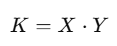

where:  
- **X** is the amount of one asset in the pool (e.g., stablecoins),
- **Y** is the amount of the traded token,  
- **K** is a constant, ensuring balance in the liquidity pool.  

### **New Price Calculation After a Trade**  

#### **1. Long Position (Buying the Asset)**  
When a trader buys an asset, they add stablecoins to the liquidity pool, increasing \(X\) and decreasing \(Y\). The new price is determined as:  

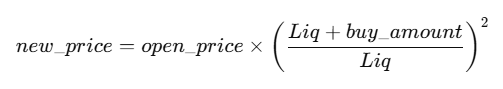

where:  
- **Liq** is the initial liquidity (i.e., the amount of stablecoins in the pool),  
- **buy_amount** is the amount of stablecoins added to the pool,  
- **open_price** is the price before the trade.  

#### **2. Short Position (Selling the Asset)**  
For short positions, the trader removes stablecoins from the liquidity pool by selling tokens. This reduces \(X\) and increases \(Y\), causing the price to drop:  

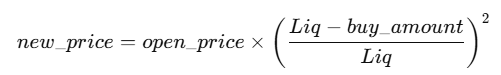

### **Percentage Price Change Calculation**  
The percentage change in price after the trade is:  

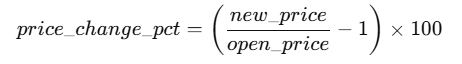

For short positions, we invert the sign:  

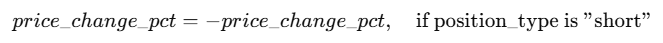

### **Key Takeaways**  
- **Liquidity pools maintain a constant product \(K\)** to ensure price stability.  
- **Buying increases price**, while **selling decreases price**, due to the impact on the asset balance.  
- **The quadratic formula** models the price shift after a trade.  
- **Short trades require inversion** to reflect correct percentage changes.  

This approach ensures an accurate and efficient calculation of price movements in AMM pools, aligning with decentralized finance (DeFi) mechanics.


In [22]:
# Calculate Trade-to-Liquidity Ratio
# This parameter represents the size of the trade relative to the available liquidity.
# A higher value indicates that the trade represents a larger portion of the liquidity pool.
df_processed['trade_to_liquidity_ratio'] = df_processed['buy_amount'] / df_processed['Liq']

# Calculate trade_amount based on position type
# This calculates the trade amount based on whether the position is 'long' or 'short'.
# For long positions, the trade amount is positive, and for short positions, it is negative.
df_processed['trade_amount'] = df_processed.apply(
    lambda row: row['buy_amount'] if row['position'] == 'long' else -row['buy_amount'], axis=1
)

# Calculate the new price considering the trade direction
# This formula calculates the new price after the trade is executed, considering the trade amount and liquidity.
# The new price reflects how the market price will change based on the liquidity and trade size.
df_processed['new_price'] = df_processed['open_price'] * ((df_processed['Liq'] + df_processed['trade_amount']) / df_processed['Liq']) ** 2

# Calculate the percentage change in price
# This calculates the percentage change in price relative to the initial price after the trade is executed.
df_processed['price_change_pct'] = (df_processed['new_price'] / df_processed['open_price'] - 1) * 100

# Invert the sign for short positions
# For short positions, the price change will be negative since we expect the price to decrease.
# This inverts the sign to ensure the percentage change reflects this correctly.
df_processed.loc[df_processed['position'] == 'short', 'price_change_pct'] *= -1

# Drop the 'trade_amount' column as it is no longer needed
# After calculating the new price and price change percentage, we no longer need the trade_amount column.
df_processed.drop(columns=['trade_amount'], inplace=True)


In [23]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3267 entries, 0 to 3266
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          3267 non-null   datetime64[ns]
 1   time                          3267 non-null   object        
 2   timezone                      3267 non-null   int64         
 3   position                      3267 non-null   object        
 4   buy_amount                    3267 non-null   float64       
 5   sell_amount                   3267 non-null   float64       
 6   sell_interval                 3267 non-null   int64         
 7   duration                      3267 non-null   int64         
 8   DCA_coin                      3267 non-null   object        
 9   OutCoin                       3267 non-null   object        
 10  MC                            3267 non-null   float64       
 11  Liq                           

In [24]:
df_processed.head()

date      time  timezone position  buy_amount  sell_amount  ...  \
0 2025-02-11  06:24:03         0    short    126110.0      15760.0  ...   
1 2025-02-11  05:57:27         0     long    232260.0       5530.0  ...   
2 2025-02-11  05:23:29         0    short    149000.0      14900.0  ...   
3 2025-02-11  04:39:15         0     long     97630.0       4880.0  ...   
4 2025-02-11  03:22:46         0     long    364020.0      72800.0  ...   

   pct_change_interval_price_10  pct_change_max_price pct_change_min_price  \
0                      2.003450             -0.000000             2.003450   
1                     -0.438451              2.047157            -1.140289   
2                     -0.000000             -1.845772             1.419824   
3                      0.964252              1.073093            -0.156409   
4                      0.000000              0.434153             0.000000   

  trade_to_liquidity_ratio  new_price  price_change_pct  
0                 0.005294   0.636595          1.056055  
1                 0.009519   0.646178          1.912831  
2                 0.013607   0.010964          2.702945  
3                 0.004781   1.252229          0.958505  
4                 0.034669   0.011836          7.053905  

[5 rows x 49 columns]

In [25]:
df_processed.describe()

date  timezone    buy_amount   sell_amount  \
count                           3267    3267.0  3.267000e+03  3.267000e+03   
mean   2025-01-24 09:08:19.173553664       0.0  3.316605e+05  2.200055e+04   
min              2025-01-13 00:00:00       0.0  7.002000e+04  1.500000e+03   
25%              2025-01-19 00:00:00       0.0  1.012450e+05  4.290000e+03   
50%              2025-01-23 00:00:00       0.0  1.728300e+05  9.300000e+03   
75%              2025-01-30 00:00:00       0.0  3.327500e+05  2.181000e+04   
max              2025-02-11 00:00:00       0.0  1.409000e+07  1.090000e+06   
std                              NaN       0.0  5.885385e+05  5.168131e+04   

       sell_interval     duration  ...  pct_change_interval_price_10  \
count    3267.000000  3267.000000  ...                   3267.000000   
mean       81.303949    45.751148  ...                      0.075281   
min        60.000000     2.000000  ...                    -97.250000   
25%        60.000000    10.000000  ...                     -1.346488   
50%        60.000000    21.000000  ...                      0.103699   
75%        60.000000    60.000000  ...                      1.946851   
max      3600.000000  1500.000000  ...                     73.936900   
std       114.501028    76.441106  ...                      7.511961   

       pct_change_max_price  pct_change_min_price  trade_to_liquidity_ratio  \
count           3267.000000           3267.000000               3267.000000   
mean              -0.570216              0.685203                  0.067076   
min              -97.800000            -47.016359                  0.000077   
25%               -1.590143             -1.187608                  0.006900   
50%                0.000000              0.052630                  0.016579   
75%                1.340433              2.127856                  0.037761   
max               84.280053             41.328175                 43.103448   
std               10.309436              5.808830                  0.825581   

          new_price  price_change_pct  
count  3.267000e+03       3267.000000  
mean   8.662886e+02         62.908940  
min    1.589691e-07      -9560.244741  
25%    9.898313e-02          1.362652  
50%    4.239469e-01          3.264240  
75%    1.326668e+00          7.464673  
max    1.814987e+05     194411.414982  
std    9.686020e+03       3409.566171  

[8 rows x 44 columns]

In [26]:
# Apply describe to specific columns: trade_to_liquidity_ratio and price_change_pct
df_processed[['trade_to_liquidity_ratio', 'price_change_pct']].describe()

trade_to_liquidity_ratio  price_change_pct
count               3267.000000       3267.000000
mean                   0.067076         62.908940
std                    0.825581       3409.566171
min                    0.000077      -9560.244741
25%                    0.006900          1.362652
50%                    0.016579          3.264240
75%                    0.037761          7.464673
max                   43.103448     194411.414982

In [27]:
# Create the first DataFrame for trade-to-liquidity analysis
df_trade_to_liquidity = df_processed[['position', 'DCA_coin', 'found_outcoin', 
                                      'trade_to_liquidity_ratio', 'pct_change_close_price',
                                      'pct_change_interval_price_1', 'pct_change_interval_price_2', 
                                      'pct_change_interval_price_3', 'pct_change_interval_price_4',
                                      'pct_change_interval_price_5', 'pct_change_interval_price_6', 
                                      'pct_change_interval_price_7', 'pct_change_interval_price_8', 
                                      'pct_change_interval_price_9', 'pct_change_interval_price_10',
                                      'pct_change_max_price', 'pct_change_min_price']]

# Create the second DataFrame for price change analysis
df_price_change = df_processed[['position', 'DCA_coin', 'found_outcoin', 'price_change_pct',
                                'new_price', 'MC', 'Liq', 'buy_amount', 
                                'pct_change_close_price', 'pct_change_interval_price_1', 
                                'pct_change_interval_price_2', 'pct_change_interval_price_3', 
                                'pct_change_interval_price_4', 'pct_change_interval_price_5', 
                                'pct_change_interval_price_6', 'pct_change_interval_price_7', 
                                'pct_change_interval_price_8', 'pct_change_interval_price_9', 
                                'pct_change_interval_price_10', 'pct_change_max_price', 
                                'pct_change_min_price']]


### **Next Steps for Analysis**

Our investigation will proceed by analyzing each of the key parameters separately to gain deeper insights into the behavior and profitability of the trading strategy.

#### **1. Trade-to-Liquidity Ratio Analysis**

The **trade-to-liquidity ratio** serves as a measure of the relative size of the trade compared to the available liquidity in the pool. We will examine how changes in this ratio affect trading performance and whether larger trades (relative to liquidity) correlate with increased volatility or profitability. Specifically, we will focus on:

- **Correlation analysis** between the trade-to-liquidity ratio and subsequent price changes or volatility.
- **Identifying thresholds** at which the trade-to-liquidity ratio significantly impacts the price change, to understand market dynamics under various liquidity conditions.
- **Impact on slippage and market behavior** for different asset pairs and liquidity conditions.

By focusing on this parameter, we aim to better understand how the trade size relative to liquidity influences price stability and the potential risks associated with larger trades.

---

#### **2. Price Change Percentage (price_change_pct) Analysis**

The **price change percentage** directly measures the price impact of each trade on the market. This parameter will be explored in-depth to assess the relationship between price changes and trading activities. Our analysis will involve:

- **Trend analysis** to identify patterns or trends in price changes based on the position (long or short) and the size of the trades.
- **Evaluating the effectiveness** of price change prediction models by correlating price changes with market events, trade volumes, and other related indicators.
- **Comparing the accuracy** of price change predictions between different market conditions and asset pairs.

Focusing on this parameter will help refine our understanding of how well the price movements reflect the efficiency and accuracy of the trading strategy and AMM dynamics.

---

Both parameters will be studied with their respective dataframes and further segmented to examine the relationships between the parameters and other related trading metrics. This approach will allow us to draw conclusions that can inform better strategies for bot trading and risk management in the future.


### **Trade-to-Liquidity Ratio Analysis**


### **Analysis Overview**:

In this analysis, you will divide your dataset into two categories based on the type of trade position (`long` and `short`). This split allows for an in-depth comparison of how the **Trade-to-Liquidity Ratio** behaves in relation to various **price change parameters** for each position type.

- **Long Position**: Refers to trades where the expectation is that the price of the asset will rise. These trades are typically executed when the trader expects to profit from an increase in the asset's value.
  
- **Short Position**: Refers to trades where the expectation is that the price of the asset will fall. In a short position, the trader borrows and sells the asset with the intention of buying it back at a lower price to profit from the price decrease.

### **Steps**:

1. **Data Splitting**: You will separate the data into two distinct datasets: one for `long` positions and one for `short` positions. This allows you to examine the specific characteristics and behavior of each type of trade independently.

2. **Visualization**: Once the data is split, you will create scatter plots (using `seaborn.scatterplot`) to visualize the relationship between the **Trade-to-Liquidity Ratio** (`trade_to_liquidity_ratio`) and various price change metrics:
   - `pct_change_close_price`
   - `pct_change_interval_price_1` to `pct_change_interval_price_10`

   Each scatter plot will display:
   - **X-axis**: The **Trade-to-Liquidity Ratio** (`trade_to_liquidity_ratio`), which represents the relationship between the trade size and liquidity.
   - **Y-axis**: The percentage change in the price of the asset over different time intervals.

   For each scatter plot:
   - **Blue points** will represent `long` positions.
   - **Red points** will represent `short` positions.

3. **Purpose of Scatter Plots**: 
   - The scatter plots will help you visually assess the correlation between **Trade-to-Liquidity Ratio** and price changes over different intervals. 
   - You will be able to see how the **trade size in relation to liquidity** influences price changes, and whether there are distinct patterns between `long` and `short` positions.

   By analyzing these plots, you can gain insights into how the **trade size** (in relation to liquidity) affects price volatility or price movements over different time frames for both position types.

---

This visualization will give you a clear picture of how **trade size** (in relation to liquidity) impacts price fluctuations, which can be important for fine-tuning trading strategies based on market conditions.


In [28]:
# Split the df_trade_to_liquidity DataFrame into two based on position type and reset the indices
df_long_trade_to_liquidity_analysis = df_trade_to_liquidity[df_trade_to_liquidity['position'] == 'long'].reset_index(drop=True)
df_short_trade_to_liquidity_analysis = df_trade_to_liquidity[df_trade_to_liquidity['position'] == 'short'].reset_index(drop=True)


In [29]:
df_long_trade_to_liquidity_analysis.describe()

trade_to_liquidity_ratio  pct_change_close_price  \
count               1467.000000             1467.000000   
mean                   0.075758                0.846057   
std                    1.144546                7.415603   
min                    0.000096              -42.601718   
25%                    0.007642               -1.617152   
50%                    0.017419                0.000000   
75%                    0.039489                1.964646   
max                   43.103448               77.777778   

       pct_change_interval_price_1  pct_change_interval_price_2  \
count                  1467.000000                  1467.000000   
mean                      0.045149                     0.168894   
std                       1.934944                     2.861160   
min                      -7.382657                   -10.627427   
25%                      -0.217961                    -0.499169   
50%                       0.000000                     0.000000   
75%                       0.217778                     0.543912   
max                      64.825000                    64.788000   

       pct_change_interval_price_3  pct_change_interval_price_4  ...  \
count                  1467.000000                  1467.000000  ...   
mean                      0.224637                     0.324436  ...   
std                       3.500900                     4.235921  ...   
min                     -19.089048                   -27.855705  ...   
25%                      -0.690524                    -0.821734  ...   
50%                       0.000000                     0.000000  ...   
75%                       0.822507                     0.974973  ...   
max                      64.792000                    63.897000  ...   

       pct_change_interval_price_7  pct_change_interval_price_8  \
count                  1467.000000                  1467.000000   
mean                      0.629525                     0.698545   
std                       6.082809                     6.550405   
min                     -32.661746                   -37.842462   
25%                      -1.114823                    -1.242328   
50%                       0.000000                     0.000000   
75%                       1.330987                     1.486787   
max                      70.644719                    63.489000   

       pct_change_interval_price_9  pct_change_interval_price_10  \
count                  1467.000000                   1467.000000   
mean                      0.724001                      0.720917   
std                       6.600336                      6.662431   
min                     -36.699119                    -40.136874   
25%                      -1.343740                     -1.383604   
50%                       0.000000                     -0.003849   
75%                       1.712936                      1.900472   
max                      65.348000                     73.936900   

       pct_change_max_price  pct_change_min_price  
count           1467.000000           1467.000000  
mean               4.197447             -2.902105  
std                8.281371              4.322874  
min                0.000000            -47.016359  
25%                0.437831             -3.440218  
50%                1.631904             -1.466905  
75%                4.268399             -0.436747  
max               84.280053              0.000000  

[8 rows x 14 columns]

In [30]:
df_short_trade_to_liquidity_analysis.describe()

trade_to_liquidity_ratio  pct_change_close_price  \
count               1800.000000             1800.000000   
mean                   0.059999               -0.466269   
std                    0.412030                8.898652   
min                    0.000077              -95.200000   
25%                    0.006336               -1.331335   
50%                    0.015939                0.337010   
75%                    0.036129                2.172350   
max                   10.828654               36.557060   

       pct_change_interval_price_1  pct_change_interval_price_2  \
count                  1800.000000                  1800.000000   
mean                     -0.018488                    -0.146240   
std                       1.180118                     3.292600   
min                      -9.546539                   -92.100000   
25%                      -0.176529                    -0.461653   
50%                      -0.000000                     0.021635   
75%                       0.232833                     0.626834   
max                       9.413043                    11.914343   

       pct_change_interval_price_3  pct_change_interval_price_4  ...  \
count                  1800.000000                  1800.000000  ...   
mean                     -0.190542                    -0.194221  ...   
std                       4.196978                     5.039336  ...   
min                     -91.350000                   -92.150000  ...   
25%                      -0.630808                    -0.699502  ...   
50%                       0.028933                     0.070077  ...   
75%                       0.830611                     1.043103  ...   
max                      25.060225                    23.713746  ...   

       pct_change_interval_price_7  pct_change_interval_price_8  \
count                  1800.000000                  1800.000000   
mean                     -0.290449                    -0.404621   
std                       6.862393                     7.573567   
min                     -95.200000                   -95.400000   
25%                      -0.938503                    -0.969286   
50%                       0.175408                     0.203982   
75%                       1.557879                     1.652118   
max                      33.516685                    27.502750   

       pct_change_interval_price_9  pct_change_interval_price_10  \
count                  1800.000000                   1800.000000   
mean                     -0.450008                     -0.450912   
std                       7.893073                      8.102877   
min                     -96.000000                    -97.250000   
25%                      -1.165867                     -1.286493   
50%                       0.191672                      0.228523   
75%                       1.839223                      1.972661   
max                      31.123946                     29.529336   

       pct_change_max_price  pct_change_min_price  
count           1800.000000           1800.000000  
mean              -4.455861              3.608859  
std               10.169835              5.194551  
min              -97.800000             -0.000000  
25%               -3.946879              0.588670  
50%               -1.312841              1.776371  
75%               -0.308618              4.427805  
max               -0.000000             41.328175  

[8 rows x 14 columns]

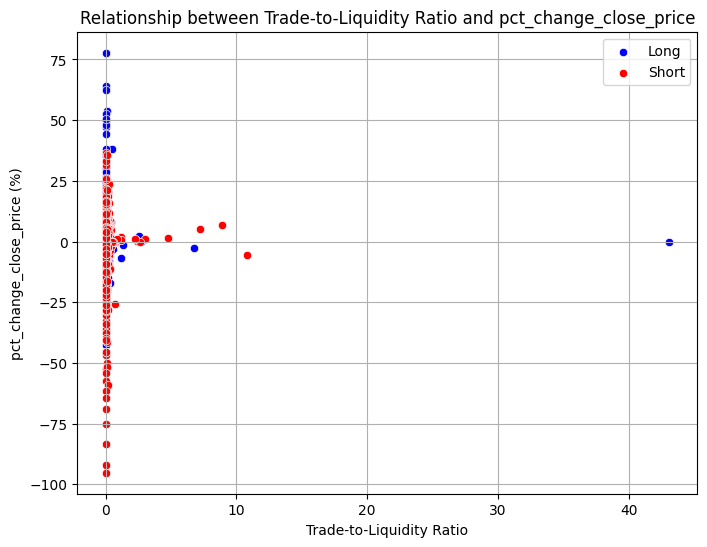

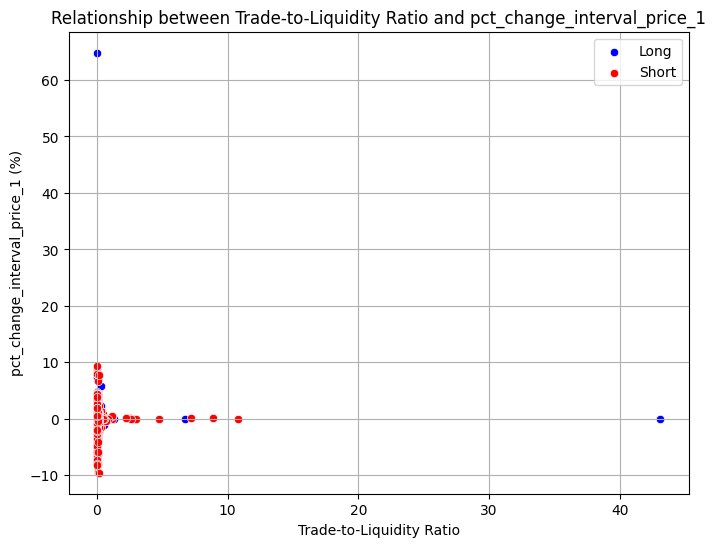

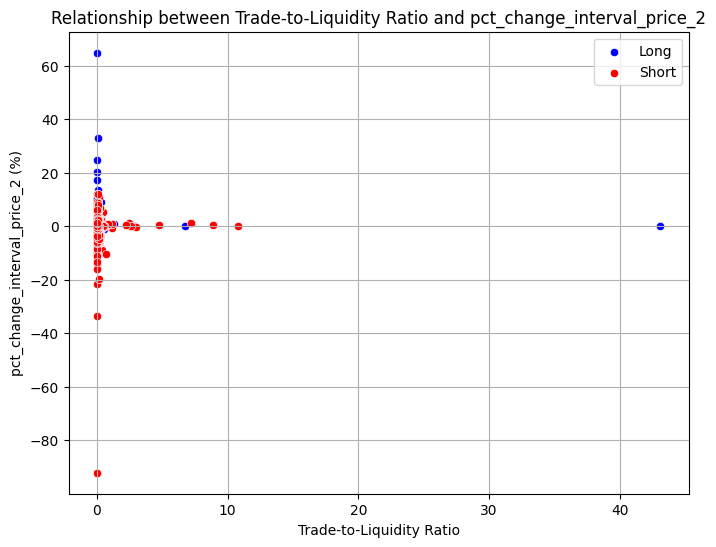

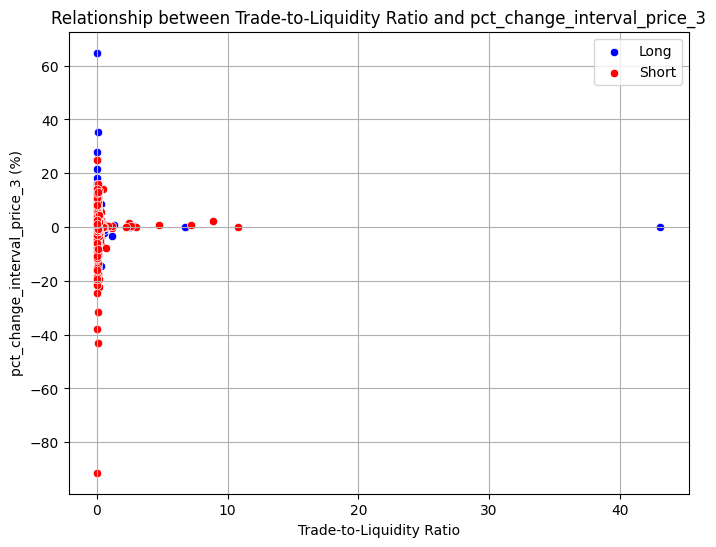

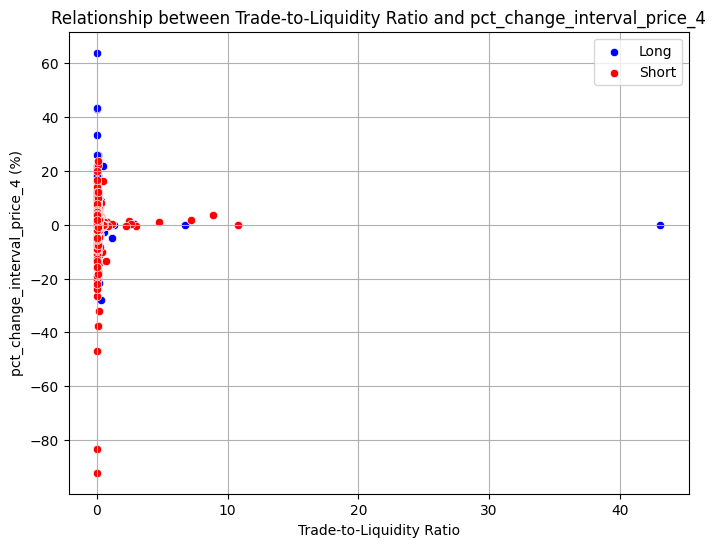

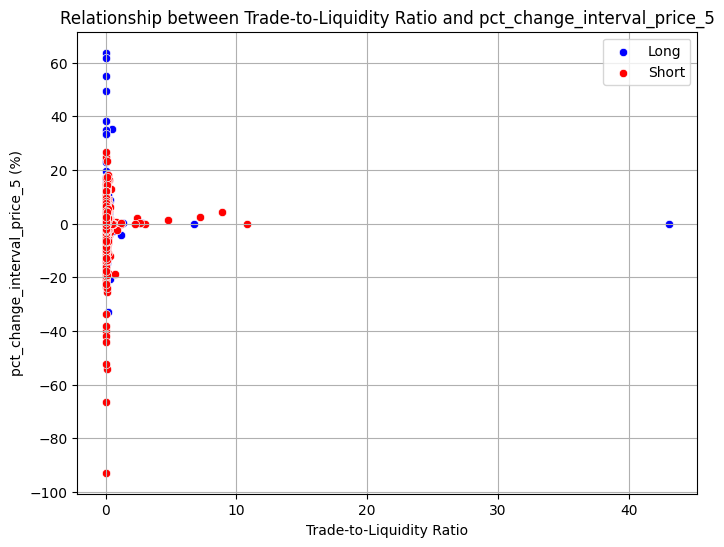

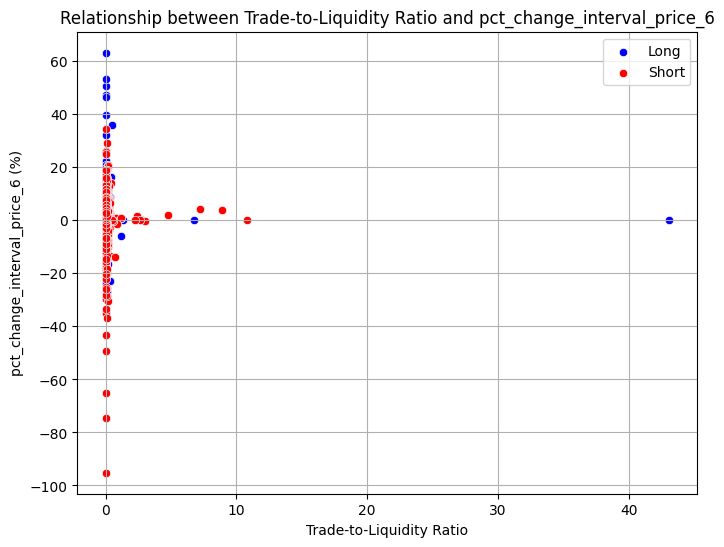

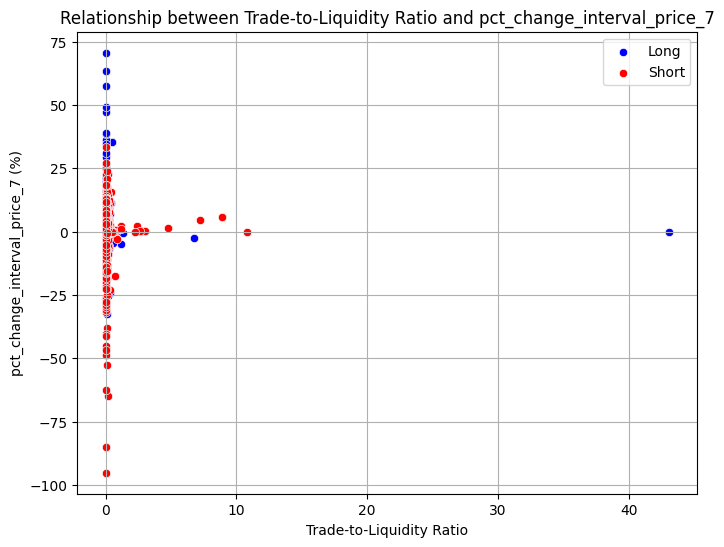

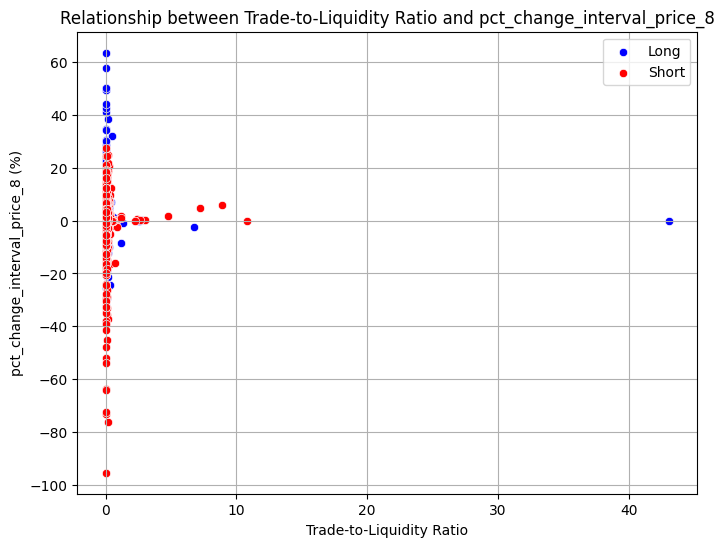

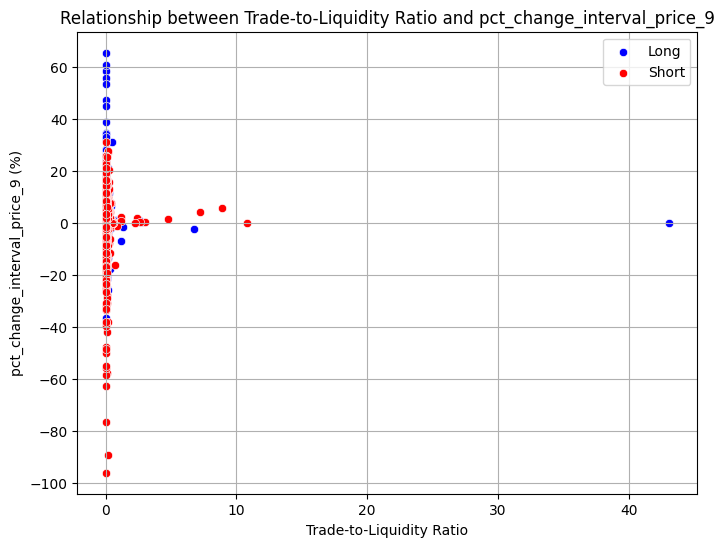

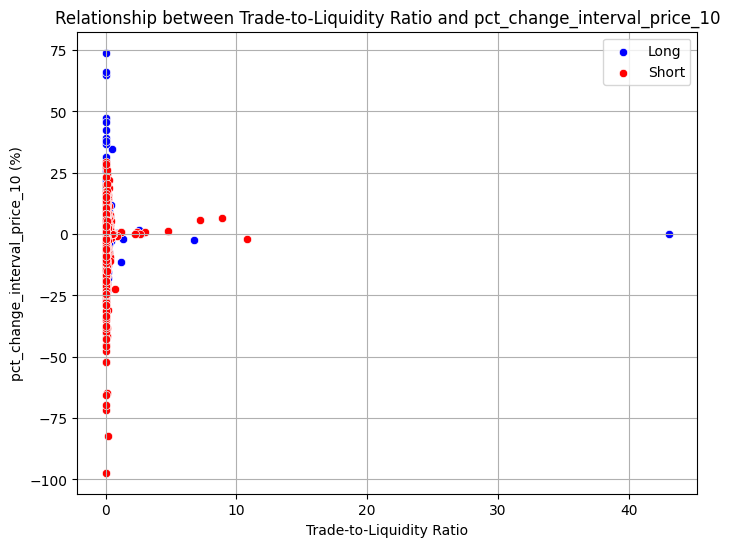

In [31]:
# List of columns for price changes
price_change_columns = ['pct_change_close_price', 'pct_change_interval_price_1', 
                        'pct_change_interval_price_2', 'pct_change_interval_price_3', 
                        'pct_change_interval_price_4', 'pct_change_interval_price_5', 
                        'pct_change_interval_price_6', 'pct_change_interval_price_7', 
                        'pct_change_interval_price_8', 'pct_change_interval_price_9', 
                        'pct_change_interval_price_10']

# Create a plot for each price change column
for column in price_change_columns:
    plt.figure(figsize=(8, 6))  # Set figure size for clarity
    sns.scatterplot(x=df_long_trade_to_liquidity_analysis['trade_to_liquidity_ratio'], 
                    y=df_long_trade_to_liquidity_analysis[column], color='blue', label='Long')
    sns.scatterplot(x=df_short_trade_to_liquidity_analysis['trade_to_liquidity_ratio'], 
                    y=df_short_trade_to_liquidity_analysis[column], color='red', label='Short')
    
    plt.title(f'Relationship between Trade-to-Liquidity Ratio and {column}')
    plt.xlabel('Trade-to-Liquidity Ratio')
    plt.ylabel(f'{column} (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

### **Analysis of Results**:

After visualizing the data through scatter plots, we observe that there is no clear correlation or dependency between the **Trade-to-Liquidity Ratio** (`trade_to_liquidity_ratio`) and the price change metrics (`pct_change_close_price`, `pct_change_interval_price_1` to `pct_change_interval_price_10`). 

However, it is important to note that the plots are heavily influenced by **outliers**, which seem to distort the data. These outliers, or extreme values, likely obscure any meaningful patterns that could exist between the trade size (in relation to liquidity) and price fluctuations. 

### **Next Steps**:

To improve the analysis and gain more accurate insights, we will focus on **handling the outliers**. By filtering or removing the extreme values, we aim to uncover any potential relationships that are masked by the presence of these outliers.

By cleaning the data in this way, we will be able to focus on the core trends and potentially reveal a more meaningful connection between **Trade-to-Liquidity Ratio** and price change metrics, especially for both **long** and **short** positions.


In [32]:
# Define a function to find outliers using IQR method for multiple columns
def detect_outliers_iqr_multiple(df, columns):
    outliers = pd.DataFrame()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers for the column and append to the outliers DataFrame
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers = pd.concat([outliers, column_outliers])

    return outliers

# Define the list of columns for price changes and trade_to_liquidity_ratio
columns_to_check = ['trade_to_liquidity_ratio']

# Find outliers in the specified columns for both long and short positions
outliers_long_trade_to_liquidity = detect_outliers_iqr_multiple(df_long_trade_to_liquidity_analysis, columns_to_check)
outliers_short_trade_to_liquidity = detect_outliers_iqr_multiple(df_short_trade_to_liquidity_analysis, columns_to_check)


In [33]:
# Function to remove outliers from the DataFrame based on columns
def remove_outliers(df, columns, outliers_df):
    # Remove outliers from the DataFrame by filtering out the rows in outliers
    cleaned_df = df.loc[~df.index.isin(outliers_df.index)]
    return cleaned_df

# Remove the outliers from the dataframes for both long and short positions
df_long_no_outliers_trade_to_liquidity = remove_outliers(df_long_trade_to_liquidity_analysis, columns_to_check, outliers_long_trade_to_liquidity)
df_short_no_outliers_trade_to_liquidity = remove_outliers(df_short_trade_to_liquidity_analysis, columns_to_check, outliers_short_trade_to_liquidity)

In [34]:
df_long_no_outliers_trade_to_liquidity.head()

position  DCA_coin found_outcoin  trade_to_liquidity_ratio  \
0     long  FARTCOIN          USDT                  0.009519   
1     long   VIRTUAL          USDT                  0.004781   
2     long       ARC          USDT                  0.034669   
3     long       ARC          USDT                  0.009674   
4     long       GFM          USDT                  0.043232   

   pct_change_close_price  pct_change_interval_price_1  ...  \
0                0.903714                     0.225534  ...   
1                0.740926                    -0.149959  ...   
2                0.000000                     0.000000  ...   
3               -1.347685                     0.000000  ...   
4               23.441154                    -0.565082  ...   

   pct_change_interval_price_7  pct_change_interval_price_8  \
0                     1.644981                     0.670294   
1                     0.898947                     0.619991   
2                     0.000000                     0.000000   
3                     0.000000                     0.000000   
4                     2.844895                     5.085737   

   pct_change_interval_price_9  pct_change_interval_price_10  \
0                    -0.228689                     -0.438451   
1                     0.986826                      0.964252   
2                     0.000000                      0.000000   
3                    -1.347685                     -1.347685   
4                     6.586126                      4.384256   

   pct_change_max_price  pct_change_min_price  
0              2.047157             -1.140289  
1              1.073093             -0.156409  
2              0.434153              0.000000  
3              0.434153             -1.347685  
4             24.493375             -4.189400  

[5 rows x 17 columns]

In [35]:
df_long_no_outliers_trade_to_liquidity.describe()

trade_to_liquidity_ratio  pct_change_close_price  \
count               1321.000000             1321.000000   
mean                   0.021200                0.918623   
std                    0.019489                7.416871   
min                    0.000096              -42.601718   
25%                    0.006691               -1.615572   
50%                    0.014396                0.000000   
75%                    0.030491                1.964379   
max                    0.087243               77.777778   

       pct_change_interval_price_1  pct_change_interval_price_2  \
count                  1321.000000                  1321.000000   
mean                      0.036860                     0.171318   
std                       2.008387                     2.957385   
min                      -7.382657                   -10.627427   
25%                      -0.217463                    -0.519509   
50%                       0.000000                     0.000000   
75%                       0.223394                     0.542215   
max                      64.825000                    64.788000   

       pct_change_interval_price_3  pct_change_interval_price_4  ...  \
count                  1321.000000                  1321.000000  ...   
mean                      0.254416                     0.362146  ...   
std                       3.551949                     4.204845  ...   
min                     -15.018797                   -18.189250  ...   
25%                      -0.722222                    -0.848593  ...   
50%                       0.000000                     0.000000  ...   
75%                       0.809419                     0.970732  ...   
max                      64.792000                    63.897000  ...   

       pct_change_interval_price_7  pct_change_interval_price_8  \
count                  1321.000000                  1321.000000   
mean                      0.690219                     0.776232   
std                       6.073960                     6.525417   
min                     -28.433523                   -37.842462   
25%                      -1.190154                    -1.281680   
50%                       0.000000                     0.000000   
75%                       1.329850                     1.501145   
max                      70.644719                    63.489000   

       pct_change_interval_price_9  pct_change_interval_price_10  \
count                  1321.000000                   1321.000000   
mean                      0.797805                      0.802355   
std                       6.634729                      6.738799   
min                     -36.699119                    -40.136874   
25%                      -1.355369                     -1.388118   
50%                      -0.001163                     -0.003849   
75%                       1.689952                      1.889209   
max                      65.348000                     73.936900   

       pct_change_max_price  pct_change_min_price  
count           1321.000000           1321.000000  
mean               4.175926             -2.828121  
std                8.346510              4.051910  
min                0.000000            -47.016359  
25%                0.436341             -3.356970  
50%                1.614391             -1.487123  
75%                4.164887             -0.446788  
max               84.280053              0.000000  

[8 rows x 14 columns]

In [36]:
df_short_no_outliers_trade_to_liquidity.head()

position   DCA_coin found_outcoin  trade_to_liquidity_ratio  \
0    short   FARTCOIN          USDC                  0.005294   
1    short        ARC          USDT                  0.013607   
2    short        CAR          USDT                  0.051223   
3    short  JAILSTOOL          USDT                  0.017958   
4    short  JAILSTOOL          USDT                  0.032168   

   pct_change_close_price  pct_change_interval_price_1  ...  \
0                0.470943                     0.460063  ...   
1               -1.828024                    -0.000000  ...   
2              -15.426252                    -0.135318  ...   
3              -21.936416                    -5.404624  ...   
4               -0.823811                    -2.843476  ...   

   pct_change_interval_price_7  pct_change_interval_price_8  \
0                     1.204557                     1.395732   
1                    -0.000000                    -0.000000   
2                    -7.848444                    -7.848444   
3                    -5.838150                   -18.497110   
4                     1.408451                     3.481265   

   pct_change_interval_price_9  pct_change_interval_price_10  \
0                     1.577581                      2.003450   
1                    -0.000000                     -0.000000   
2                    -6.089310                     -5.953992   
3                   -25.722543                    -27.167630   
4                     3.454690                      5.155461   

   pct_change_max_price  pct_change_min_price  
0             -0.000000              2.003450  
1             -1.845772              1.419824  
2            -15.967524             -0.000000  
3            -38.005780              8.901734  
4             -3.640712              8.291257  

[5 rows x 17 columns]

In [37]:
df_short_no_outliers_trade_to_liquidity.describe()

trade_to_liquidity_ratio  pct_change_close_price  \
count               1609.000000             1609.000000   
mean                   0.018951               -0.598937   
std                    0.017673                8.694158   
min                    0.000077              -95.200000   
25%                    0.005294               -1.340882   
50%                    0.013755                0.317604   
75%                    0.028079                2.115560   
max                    0.079727               36.557060   

       pct_change_interval_price_1  pct_change_interval_price_2  \
count                  1609.000000                  1609.000000   
mean                     -0.020735                    -0.173991   
std                       1.173183                     3.312517   
min                      -9.385113                   -92.100000   
25%                      -0.203726                    -0.493755   
50%                       0.000000                     0.010496   
75%                       0.234742                     0.612653   
max                       9.413043                    11.914343   

       pct_change_interval_price_3  pct_change_interval_price_4  ...  \
count                  1609.000000                  1609.000000  ...   
mean                     -0.227522                    -0.247782  ...   
std                       4.059393                     4.932887  ...   
min                     -91.350000                   -92.150000  ...   
25%                      -0.639702                    -0.732609  ...   
50%                       0.020533                     0.047438  ...   
75%                       0.793976                     0.986977  ...   
max                      25.060225                    22.163736  ...   

       pct_change_interval_price_7  pct_change_interval_price_8  \
count                  1609.000000                  1609.000000   
mean                     -0.371940                    -0.473245   
std                       6.647436                     7.179923   
min                     -95.200000                   -95.400000   
25%                      -0.948509                    -1.001712   
50%                       0.160514                     0.180021   
75%                       1.472784                     1.599467   
max                      33.516685                    27.502750   

       pct_change_interval_price_9  pct_change_interval_price_10  \
count                  1609.000000                   1609.000000   
mean                     -0.544353                     -0.545485   
std                       7.386497                      7.647578   
min                     -96.000000                    -97.250000   
25%                      -1.178796                     -1.299521   
50%                       0.153950                      0.208203   
75%                       1.705703                      1.859890   
max                      31.123946                     29.529336   

       pct_change_max_price  pct_change_min_price  
count           1609.000000           1609.000000  
mean              -4.224027              3.359771  
std                9.566867              4.791059  
min              -97.800000             -0.000000  
25%               -3.858030              0.567346  
50%               -1.286499              1.682243  
75%               -0.307341              4.216036  
max               -0.000000             41.328175  

[8 rows x 14 columns]

In [38]:
outliers_long_trade_to_liquidity.describe()

trade_to_liquidity_ratio  pct_change_close_price  \
count                146.000000              146.000000   
mean                   0.569403                0.189483   
std                    3.601174                7.397108   
min                    0.087471              -20.805683   
25%                    0.106036               -1.625864   
50%                    0.140516                0.006475   
75%                    0.229575                1.976536   
max                   43.103448               53.800836   

       pct_change_interval_price_1  pct_change_interval_price_2  \
count                   146.000000                   146.000000   
mean                      0.120142                     0.146963   
std                       1.061633                     1.773485   
min                      -2.171904                    -8.834779   
25%                      -0.228119                    -0.354212   
50%                       0.000000                     0.047049   
75%                       0.152940                     0.662685   
max                       7.019348                     8.930426   

       pct_change_interval_price_3  pct_change_interval_price_4  ...  \
count                   146.000000                   146.000000  ...   
mean                     -0.044810                    -0.016760  ...   
std                       2.997002                     4.508265  ...   
min                     -19.089048                   -27.855705  ...   
25%                      -0.466432                    -0.579443  ...   
50%                       0.035547                     0.050259  ...   
75%                       0.941202                     1.023868  ...   
max                       8.722741                    21.985188  ...   

       pct_change_interval_price_7  pct_change_interval_price_8  \
count                   146.000000                   146.000000   
mean                      0.080363                    -0.004364   
std                       6.156118                     6.754681   
min                     -32.661746                   -29.429510   
25%                      -0.757638                    -1.026303   
50%                       0.127054                    -0.008467   
75%                       1.487928                     1.301663   
max                      35.426108                    38.569509   

       pct_change_interval_price_9  pct_change_interval_price_10  \
count                   146.000000                    146.000000   
mean                      0.056227                     -0.015929   
std                       6.262773                      5.896629   
min                     -25.661700                    -23.066869   
25%                      -1.060339                     -1.232250   
50%                       0.000049                     -0.004510   
75%                       1.892698                      2.018796   
max                      30.938433                     34.685531   

       pct_change_max_price  pct_change_min_price  
count            146.000000            146.000000  
mean               4.392162             -3.571506  
std                7.691003              6.242853  
min                0.000000            -35.616832  
25%                0.470511             -4.034782  
50%                2.051058             -1.331006  
75%                5.101068             -0.380709  
max               54.941087              0.000000  

[8 rows x 14 columns]

In [39]:
outliers_short_trade_to_liquidity.describe()

trade_to_liquidity_ratio  pct_change_close_price  \
count                191.000000              191.000000   
mean                   0.405795                0.651340   
std                    1.212569               10.423309   
min                    0.081102              -58.879711   
25%                    0.107504               -1.126498   
50%                    0.140537                0.640685   
75%                    0.216219                4.124787   
max                   10.828654               35.503247   

       pct_change_interval_price_1  pct_change_interval_price_2  \
count                   191.000000                   191.000000   
mean                      0.000434                     0.087543   
std                       1.240057                     3.118240   
min                      -9.546539                   -19.625482   
25%                      -0.076090                    -0.301586   
50%                       0.000000                     0.144602   
75%                       0.184030                     1.062609   
max                       7.692308                    10.920456   

       pct_change_interval_price_3  pct_change_interval_price_4  ...  \
count                   191.000000                   191.000000  ...   
mean                      0.120974                     0.256979  ...   
std                       5.216509                     5.855216  ...   
min                     -43.267498                   -37.676479  ...   
25%                      -0.445598                    -0.540045  ...   
50%                       0.151163                     0.269365  ...   
75%                       1.337018                     1.924889  ...   
max                      16.122449                    23.713746  ...   

       pct_change_interval_price_7  pct_change_interval_price_8  \
count                   191.000000                   191.000000   
mean                      0.396036                     0.173473   
std                       8.449115                    10.316772   
min                     -65.023232                   -76.226123   
25%                      -0.676630                    -0.719010   
50%                       0.463688                     0.527530   
75%                       2.489756                     2.827396   
max                      23.818422                    24.730028   

       pct_change_interval_price_9  pct_change_interval_price_10  \
count                   191.000000                    191.000000   
mean                      0.344757                      0.345777   
std                      11.288282                     11.224040   
min                     -89.081053                    -82.111513   
25%                      -0.900665                     -1.151566   
50%                       0.578035                      0.543894   
75%                       3.682432                      3.663613   
max                      27.434281                     26.298701   

       pct_change_max_price  pct_change_min_price  
count            191.000000            191.000000  
mean              -6.408849              5.707193  
std               14.156168              7.501524  
min              -90.165204             -0.000000  
25%               -5.276768              0.847243  
50%               -1.394268              2.562863  
75%               -0.323606              7.421141  
max               -0.000000             35.503247  

[8 rows x 14 columns]

# Data Analysis and Outlier Handling

## Trade-to-Liquidity Ratio Outliers

Since outliers in the **Trade-to-Liquidity Ratio** represent a significant class, they need to be examined separately. However, for better visualization and analysis, we will first remove these outliers.  

### Outlier Thresholds  

Based on statistical analysis:  
- For **long positions**, the third quartile (Q3) is **0.229575**, while the maximum value reaches **43.1**.  
- For **short positions**, Q3 is **0.21621**, with a maximum value of **10.828654**.  

These extreme values deviate significantly from the majority of the data, making trend analysis challenging.  

By filtering out these extreme values, we can obtain clearer insights into the underlying patterns in the data. After handling outliers, we will proceed with further modeling and evaluation to understand the impact of **Trade-to-Liquidity Ratio** on price changes.


In [40]:
outliers_outliers_long_trade_to_liquidity = detect_outliers_iqr_multiple(outliers_long_trade_to_liquidity, columns_to_check)
outliers_outliers_short_trade_to_liquidity = detect_outliers_iqr_multiple(outliers_short_trade_to_liquidity, columns_to_check) 

outliers_long_trade_to_liquidity_cleaned = remove_outliers(outliers_long_trade_to_liquidity, columns_to_check, outliers_outliers_long_trade_to_liquidity)
outliers_short_trade_to_liquidity_cleaned = remove_outliers(outliers_short_trade_to_liquidity, columns_to_check, outliers_outliers_short_trade_to_liquidity)

In [41]:
outliers_long_trade_to_liquidity_cleaned.describe()

trade_to_liquidity_ratio  pct_change_close_price  \
count                131.000000              131.000000   
mean                   0.157833                0.009950   
std                    0.075225                7.019441   
min                    0.087471              -20.805683   
25%                    0.101406               -1.664679   
50%                    0.131312                0.110132   
75%                    0.190081                2.053607   
max                    0.397820               53.800836   

       pct_change_interval_price_1  pct_change_interval_price_2  \
count                   131.000000                   131.000000   
mean                      0.143790                     0.156545   
std                       1.111919                     1.864730   
min                      -2.171904                    -8.834779   
25%                      -0.258555                    -0.378450   
50%                       0.000000                     0.063778   
75%                       0.152638                     0.748174   
max                       7.019348                     8.930426   

       pct_change_interval_price_3  pct_change_interval_price_4  ...  \
count                   131.000000                   131.000000  ...   
mean                     -0.020295                    -0.128762  ...   
std                       3.140882                     4.322165  ...   
min                     -19.089048                   -27.855705  ...   
25%                      -0.481593                    -0.593344  ...   
50%                       0.039479                     0.053696  ...   
75%                       1.070416                     1.228588  ...   
max                       8.722741                     8.722741  ...   

       pct_change_interval_price_7  pct_change_interval_price_8  \
count                   131.000000                   131.000000   
mean                     -0.088824                    -0.165867   
std                       5.673972                     6.511312   
min                     -32.661746                   -29.429510   
25%                      -0.731576                    -1.060591   
50%                       0.127226                     0.000000   
75%                       1.778535                     1.510443   
max                      11.331967                    38.569509   

       pct_change_interval_price_9  pct_change_interval_price_10  \
count                   131.000000                    131.000000   
mean                     -0.101454                     -0.154175   
std                       5.992161                      5.325294   
min                     -25.661700                    -23.066869   
25%                      -1.030335                     -1.226626   
50%                       0.000098                     -0.000688   
75%                       2.149100                      2.315028   
max                      21.188592                     12.437811   

       pct_change_max_price  pct_change_min_price  
count            131.000000            131.000000  
mean               4.495928             -3.773365  
std                7.389087              6.486753  
min                0.000000            -35.616832  
25%                0.471426             -4.210905  
50%                2.242249             -1.413997  
75%                5.339132             -0.459502  
max               54.941087              0.000000  

[8 rows x 14 columns]

In [42]:
outliers_short_trade_to_liquidity_cleaned.describe()

trade_to_liquidity_ratio  pct_change_close_price  \
count                168.000000              168.000000   
mean                   0.152328                0.801156   
std                    0.068302               10.889994   
min                    0.081102              -58.879711   
25%                    0.103280               -1.199594   
50%                    0.133319                0.877615   
75%                    0.175778                4.675730   
max                    0.376050               35.503247   

       pct_change_interval_price_1  pct_change_interval_price_2  \
count                   168.000000                   168.000000   
mean                     -0.007137                     0.096261   
std                       1.319368                     3.191722   
min                      -9.546539                   -19.625482   
25%                      -0.085725                    -0.438345   
50%                      -0.000000                     0.145999   
75%                       0.244650                     1.142107   
max                       7.692308                    10.920456   

       pct_change_interval_price_3  pct_change_interval_price_4  ...  \
count                   168.000000                   168.000000  ...   
mean                      0.063231                     0.229541  ...   
std                       5.415757                     6.016858  ...   
min                     -43.267498                   -37.676479  ...   
25%                      -0.604639                    -0.671993  ...   
50%                       0.179966                     0.315523  ...   
75%                       1.617065                     2.052137  ...   
max                      16.122449                    23.713746  ...   

       pct_change_interval_price_7  pct_change_interval_price_8  \
count                   168.000000                   168.000000   
mean                      0.386108                     0.155946   
std                       8.801386                    10.871654   
min                     -65.023232                   -76.226123   
25%                      -0.784138                    -0.769774   
50%                       0.576415                     0.560702   
75%                       2.924405                     3.031862   
max                      23.818422                    24.730028   

       pct_change_interval_price_9  pct_change_interval_price_10  \
count                   168.000000                    168.000000   
mean                      0.368797                      0.429277   
std                      11.943902                     11.811879   
min                     -89.081053                    -82.111513   
25%                      -1.004862                     -1.224596   
50%                       0.704410                      0.650168   
75%                       3.969001                      4.078536   
max                      27.434281                     26.298701   

       pct_change_max_price  pct_change_min_price  
count            168.000000            168.000000  
mean              -7.013327              6.163642  
std               14.861630              7.668656  
min              -90.165204             -0.000000  
25%               -6.483659              1.068413  
50%               -1.608529              3.112451  
75%               -0.379964              7.858757  
max               -0.000000             35.503247  

[8 rows x 14 columns]

## Visualization and Correlation Analysis


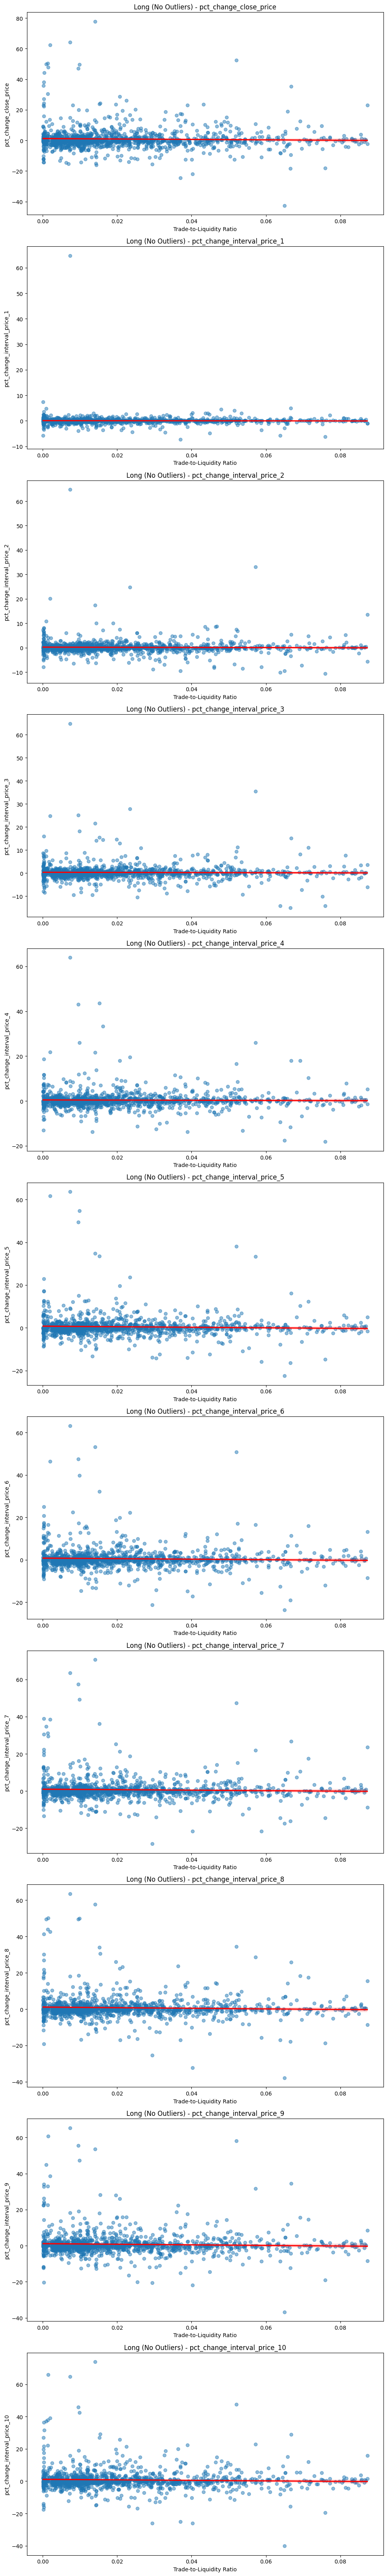

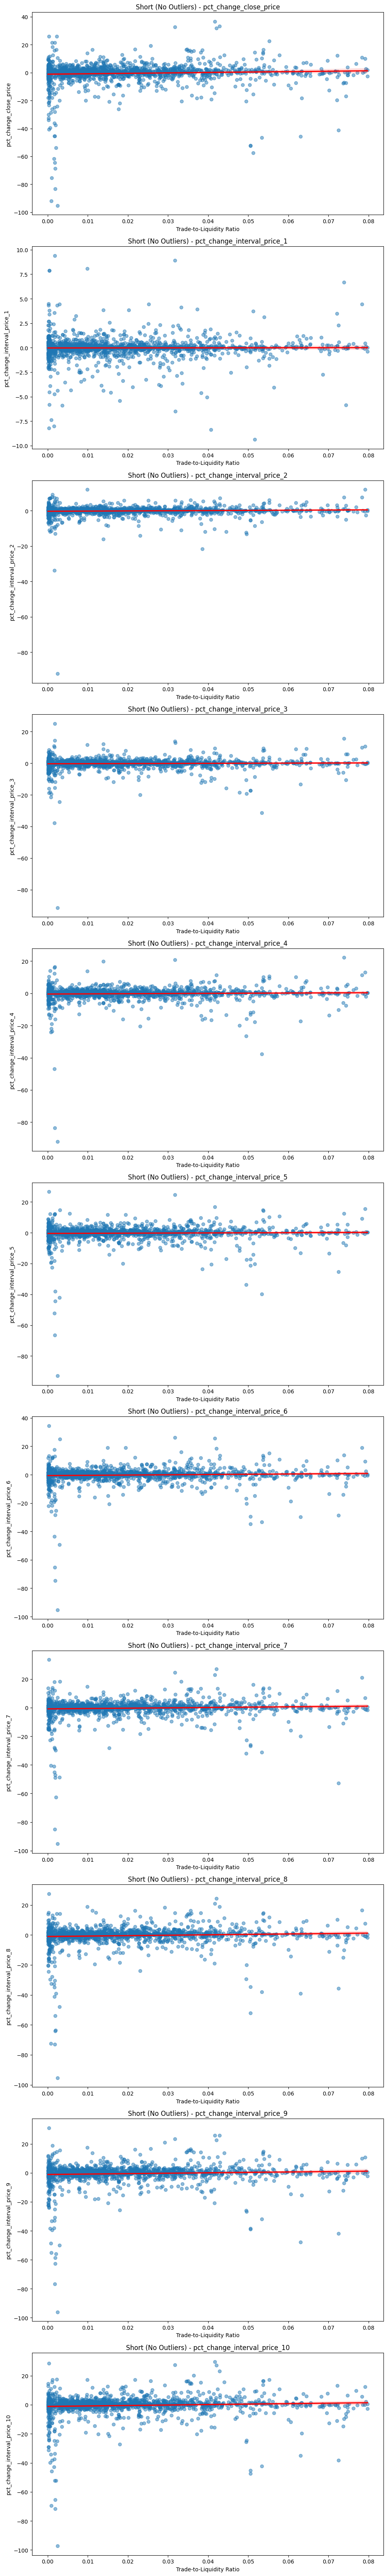

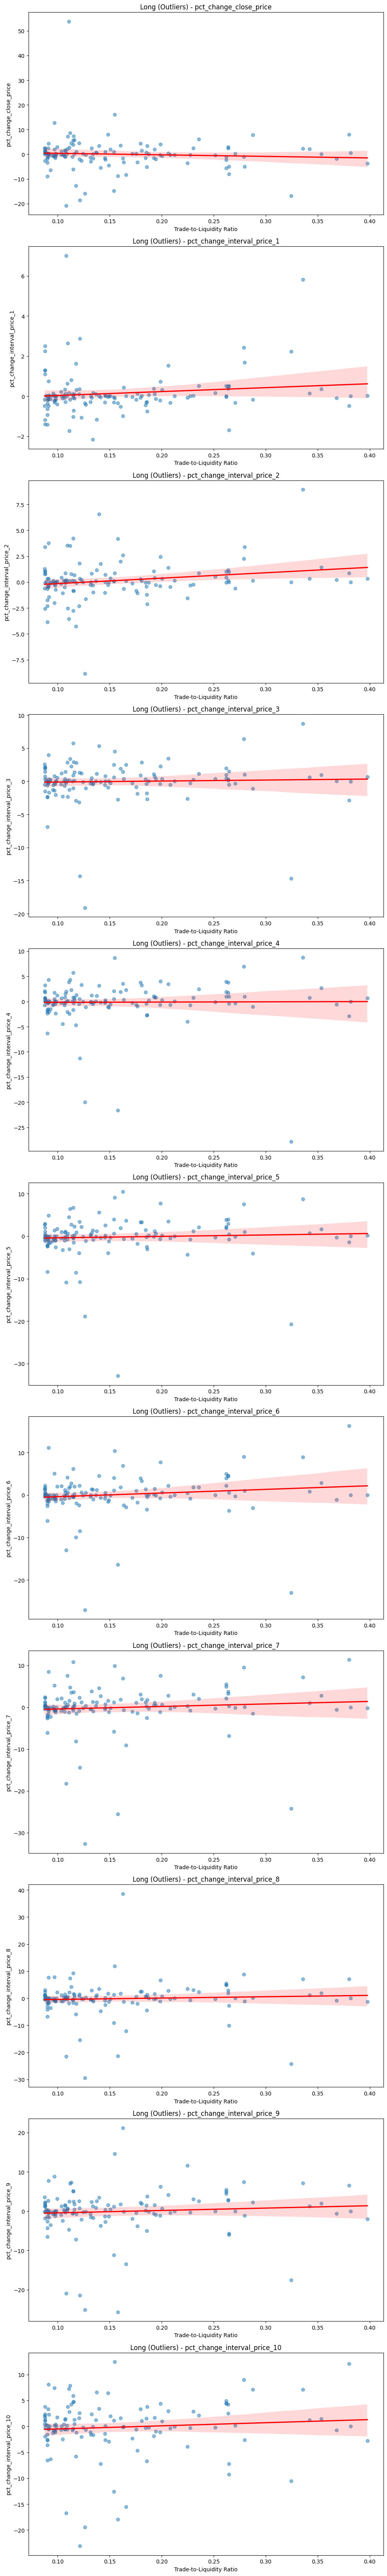

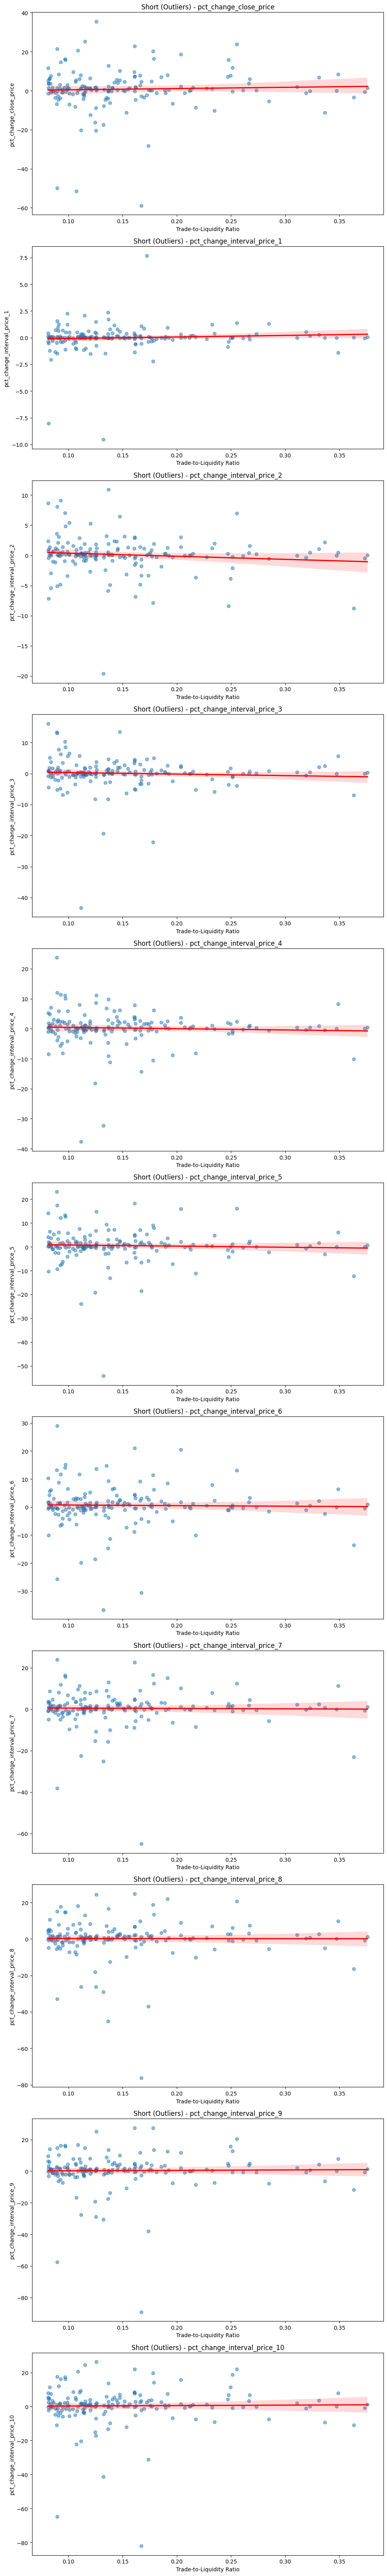

In [43]:
# Define the columns with price change parameters
price_change_columns = [
    'pct_change_close_price', 'pct_change_interval_price_1', 'pct_change_interval_price_2', 
    'pct_change_interval_price_3', 'pct_change_interval_price_4', 'pct_change_interval_price_5', 
    'pct_change_interval_price_6', 'pct_change_interval_price_7', 'pct_change_interval_price_8', 
    'pct_change_interval_price_9', 'pct_change_interval_price_10'
]

# Function to create scatter plots with correlation lines
def plot_trade_to_liquidity_vs_price_changes(df, position_type):
    num_columns = len(price_change_columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 6 * num_columns))  # One graph per row

    for i, column in enumerate(price_change_columns):
        sns.regplot(x=df['trade_to_liquidity_ratio'], y=df[column], ax=axes[i], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
        axes[i].set_title(f'{position_type} - {column}')
        axes[i].set_xlabel('Trade-to-Liquidity Ratio')
        axes[i].set_ylabel(f'{column}')

    plt.tight_layout()
    plt.show()

# Plotting for long and short positions with and without outliers
plot_trade_to_liquidity_vs_price_changes(df_long_no_outliers_trade_to_liquidity, "Long (No Outliers)")
plot_trade_to_liquidity_vs_price_changes(df_short_no_outliers_trade_to_liquidity, "Short (No Outliers)")
plot_trade_to_liquidity_vs_price_changes(outliers_long_trade_to_liquidity_cleaned, "Long (Outliers)")
plot_trade_to_liquidity_vs_price_changes(outliers_short_trade_to_liquidity_cleaned, "Short (Outliers)")

### Conclusion  

Examining the scatter plots and correlation lines, there is no strong dependency observed. This suggests that the selected trade_to_liquidity_ratio coefficient does not have a significant impact. The next steps involve analyzing the correlation values and determining their p-value.  


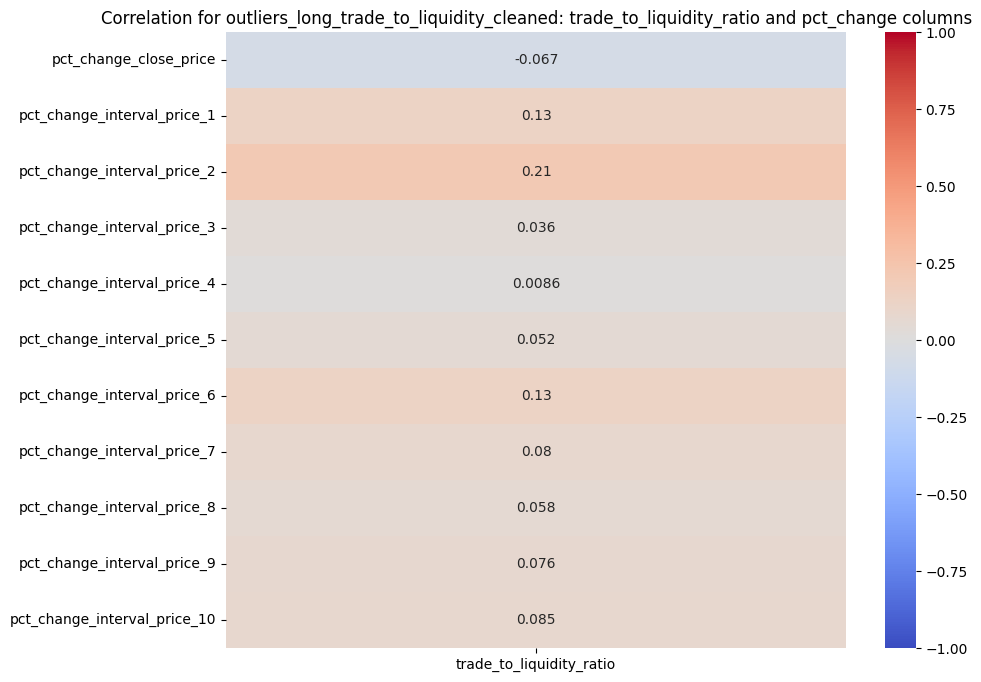

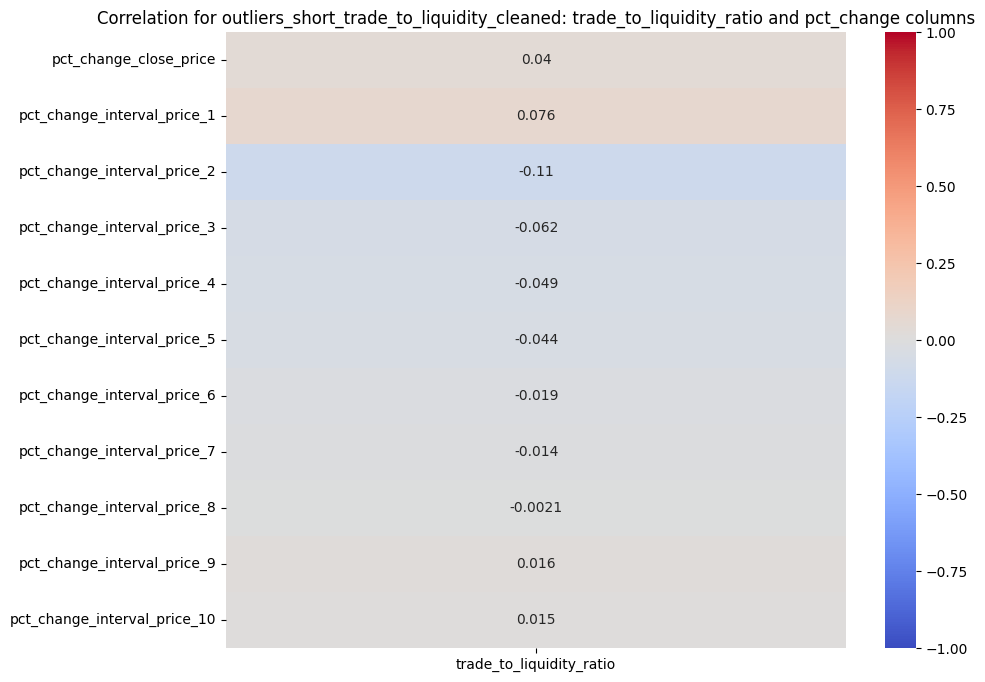

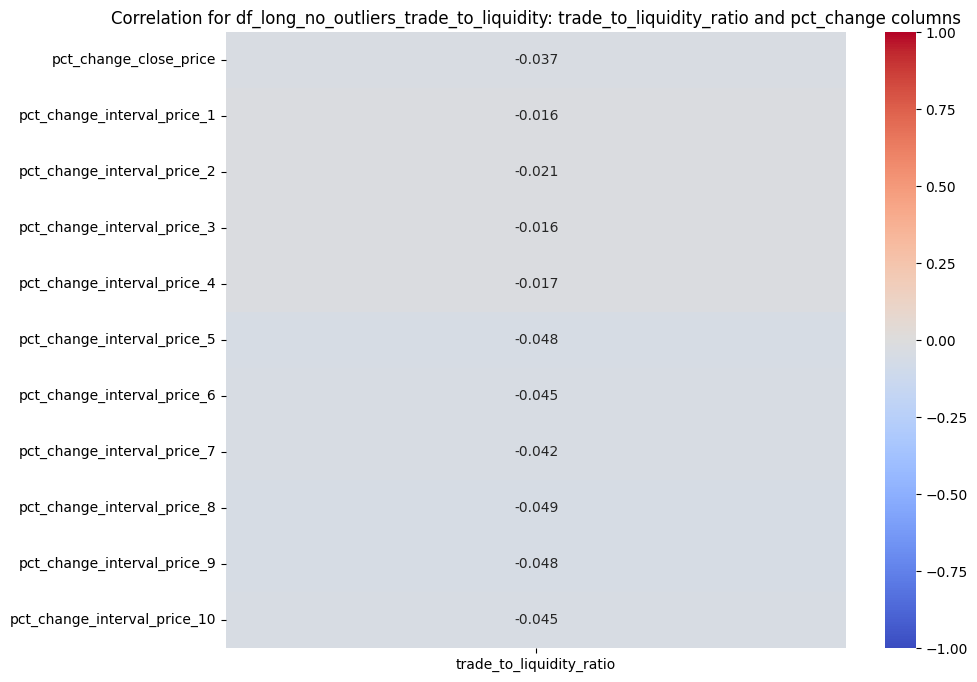

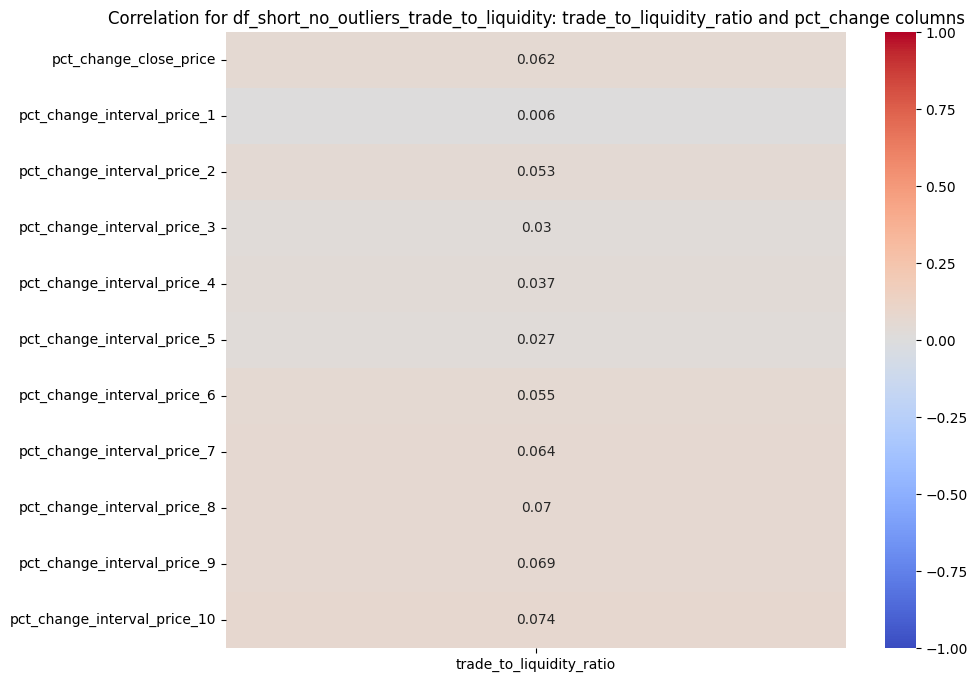

In [44]:
pct_change_columns = [
    'pct_change_close_price', 'pct_change_interval_price_1', 'pct_change_interval_price_2', 
    'pct_change_interval_price_3', 'pct_change_interval_price_4', 'pct_change_interval_price_5', 
    'pct_change_interval_price_6', 'pct_change_interval_price_7', 'pct_change_interval_price_8', 
    'pct_change_interval_price_9', 'pct_change_interval_price_10'
]
# Function to calculate correlation and plot heatmap with dataframe name
def plot_correlation_heatmap(df, trade_to_liquidity_column, pct_change_columns, df_name):
    correlation = df[[trade_to_liquidity_column] + pct_change_columns].corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation[trade_to_liquidity_column].drop(trade_to_liquidity_column).to_frame(), 
                annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
    plt.title(f"Correlation for {df_name}: {trade_to_liquidity_column} and pct_change columns")
    plt.show()

# Visualize correlation for each dataframe with appropriate dataframe names
plot_correlation_heatmap(outliers_long_trade_to_liquidity_cleaned, 'trade_to_liquidity_ratio', pct_change_columns, 'outliers_long_trade_to_liquidity_cleaned')
plot_correlation_heatmap(outliers_short_trade_to_liquidity_cleaned, 'trade_to_liquidity_ratio', pct_change_columns, 'outliers_short_trade_to_liquidity_cleaned')
plot_correlation_heatmap(df_long_no_outliers_trade_to_liquidity, 'trade_to_liquidity_ratio', pct_change_columns, 'df_long_no_outliers_trade_to_liquidity')
plot_correlation_heatmap(df_short_no_outliers_trade_to_liquidity, 'trade_to_liquidity_ratio', pct_change_columns, 'df_short_no_outliers_trade_to_liquidity')

In [45]:
# Function to calculate correlation and p-value for each column
def calculate_correlation_and_p_value(df, trade_to_liquidity_column, pct_change_columns):
    results = {}
    
    # Loop through each percentage change column
    for column in pct_change_columns:
        # Calculate Pearson correlation and p-value
        correlation, p_value = pearsonr(df[trade_to_liquidity_column], df[column])
        results[column] = {'correlation': correlation, 'p_value': p_value}
    
    return results

# Calculate correlation and p-value for each dataframe
results_long_cleaned = calculate_correlation_and_p_value(outliers_long_trade_to_liquidity_cleaned, 'trade_to_liquidity_ratio', pct_change_columns)
results_short_cleaned = calculate_correlation_and_p_value(outliers_short_trade_to_liquidity_cleaned, 'trade_to_liquidity_ratio', pct_change_columns)
results_long_no_outliers = calculate_correlation_and_p_value(df_long_no_outliers_trade_to_liquidity, 'trade_to_liquidity_ratio', pct_change_columns)
results_short_no_outliers = calculate_correlation_and_p_value(df_short_no_outliers_trade_to_liquidity, 'trade_to_liquidity_ratio', pct_change_columns)

# Print the results
print("Results for outliers_long_trade_to_liquidity_cleaned:")
for column, values in results_long_cleaned.items():
    print(f"{column}: Correlation = {values['correlation']:.4f}, p-value = {values['p_value']:.4f}")
    
print("\nResults for outliers_short_trade_to_liquidity_cleaned:")
for column, values in results_short_cleaned.items():
    print(f"{column}: Correlation = {values['correlation']:.4f}, p-value = {values['p_value']:.4f}")
    
print("\nResults for df_long_no_outliers_trade_to_liquidity:")
for column, values in results_long_no_outliers.items():
    print(f"{column}: Correlation = {values['correlation']:.4f}, p-value = {values['p_value']:.4f}")
    
print("\nResults for df_short_no_outliers_trade_to_liquidity:")
for column, values in results_short_no_outliers.items():
    print(f"{column}: Correlation = {values['correlation']:.4f}, p-value = {values['p_value']:.4f}")

Results for outliers_long_trade_to_liquidity_cleaned:
pct_change_close_price: Correlation = -0.0669, p-value = 0.4478
pct_change_interval_price_1: Correlation = 0.1322, p-value = 0.1322
pct_change_interval_price_2: Correlation = 0.2110, p-value = 0.0155
pct_change_interval_price_3: Correlation = 0.0359, p-value = 0.6840
pct_change_interval_price_4: Correlation = 0.0086, p-value = 0.9228
pct_change_interval_price_5: Correlation = 0.0517, p-value = 0.5579
pct_change_interval_price_6: Correlation = 0.1326, p-value = 0.1311
pct_change_interval_price_7: Correlation = 0.0799, p-value = 0.3642
pct_change_interval_price_8: Correlation = 0.0577, p-value = 0.5129
pct_change_interval_price_9: Correlation = 0.0761, p-value = 0.3875
pct_change_interval_price_10: Correlation = 0.0851, p-value = 0.3336

Results for outliers_short_trade_to_liquidity_cleaned:
pct_change_close_price: Correlation = 0.0398, p-value = 0.6081
pct_change_interval_price_1: Correlation = 0.0759, p-value = 0.3280
pct_change_int

### **Conclusion**  

After analyzing the correlation values and **p-values**, we can confidently **reject the initial hypothesis**. There is **no clear positive relationship** between large token purchases relative to liquidity and subsequent price increases.  

#### **Key Findings:**  
- **All correlations are weak**, indicating no strong dependency.  
- **p-value analysis** confirms that these correlations are **random** and not statistically significant.  
- The **token price is influenced by many factors**, making it difficult for a single player to have a consistent impact.  
- While some purchases do affect the price, it is **impossible to separate them** from those that do not, especially when external factors cause price declines.  

🚫 **Final Verdict:** Using **DCA bot positions** for systematic profit is **not feasible**.  

### **Next Steps:**  
We will now proceed with a **trade simulation** to further validate these findings.  


### Simulation Analysis

In this section, we will conduct a **simulation** to analyze the potential outcomes of investing in specific trades based on various dataframes. 

We will examine four different datasets:

1. **`outliers_long_trade_to_liquidity_cleaned`**
2. **`outliers_short_trade_to_liquidity_cleaned`**
3. **`df_long_no_outliers_trade_to_liquidity`**
4. **`df_short_no_outliers_trade_to_liquidity`**

For each of these datasets, we will simulate the investment of **$1,000** in the respective trades, tracking how the investment would perform in terms of returns. Specifically, we will analyze the **opening** and **closing prices** of the trades to assess potential gains. The goal is to calculate the total return based on each dataset and examine the success rate (Win Rate) of trades within these datasets.

Additionally, we will look at how **trade_to_liquidity_ratio** impacts the overall performance and whether higher liquidity correlates with better returns in these trading scenarios.


In [46]:
def calculate_and_simulate(df, initial_capital=1000, max_investment_percent=1):
    """
    Calculate the win rate and simulate investment for the given DataFrame.
    Merges the results on the 'Interval' column to avoid duplication.
    
    :param df: DataFrame to process
    :param initial_capital: Initial investment capital (default: 1000)
    :param max_investment_percent: Maximum percentage of capital to invest per trade (default: 1)
    :return: Merged DataFrame containing win rate and simulation results
    """
    # Calculate win rate
    win_rate_df = calculate_win_rate(df)
    
    # Run investment simulation
    simulation_df = simulate_investment_for_interval(df, initial_capital, max_investment_percent)
    
    # Merge results on 'Interval' column
    combined_df = pd.merge(win_rate_df, simulation_df, on='Interval')

    return combined_df

In [47]:
# Display DataFrame
display(calculate_and_simulate(outliers_long_trade_to_liquidity_cleaned))

Interval    WinRate  Initial Capital  Final Capital
0         pct_change_close_price  51.145038             1000    1000.098369
1    pct_change_interval_price_1  41.984733             1000    1001.884604
2    pct_change_interval_price_2  51.908397             1000    1002.050557
3    pct_change_interval_price_3  52.671756             1000     999.727751
4    pct_change_interval_price_4  53.435115             1000     998.302494
5    pct_change_interval_price_5  48.854962             1000     997.515355
6    pct_change_interval_price_6  48.854962             1000    1001.139792
7    pct_change_interval_price_7  54.198473             1000     998.816153
8    pct_change_interval_price_8  48.854962             1000     997.801989
9    pct_change_interval_price_9  50.381679             1000     998.648509
10  pct_change_interval_price_10  48.854962             1000     997.963930

In [48]:
# Display DataFrame
display(calculate_and_simulate(outliers_short_trade_to_liquidity_cleaned))

Interval    WinRate  Initial Capital  Final Capital
0         pct_change_close_price  61.309524             1000    1013.449370
1    pct_change_interval_price_1  49.404762             1000     999.878660
2    pct_change_interval_price_2  58.333333             1000    1001.609958
3    pct_change_interval_price_3  56.547619             1000    1001.038294
4    pct_change_interval_price_4  59.523810             1000    1003.833313
5    pct_change_interval_price_5  59.523810             1000    1008.825089
6    pct_change_interval_price_6  55.357143             1000    1010.241352
7    pct_change_interval_price_7  60.714286             1000    1006.442354
8    pct_change_interval_price_8  60.714286             1000    1002.524156
9    pct_change_interval_price_9  61.904762             1000    1006.094739
10  pct_change_interval_price_10  60.714286             1000    1007.120146

In [49]:
# Display DataFrame
display(calculate_and_simulate(df_long_no_outliers_trade_to_liquidity))

Interval    WinRate  Initial Capital  Final Capital
0         pct_change_close_price  48.978047             1000    1128.604772
1    pct_change_interval_price_1  44.360333             1000    1004.854458
2    pct_change_interval_price_2  46.101438             1000    1022.829958
3    pct_change_interval_price_3  49.129447             1000    1034.093129
4    pct_change_interval_price_4  48.675246             1000    1048.879120
5    pct_change_interval_price_5  47.615443             1000    1066.362077
6    pct_change_interval_price_6  47.918244             1000    1074.715483
7    pct_change_interval_price_7  48.978047             1000    1095.194316
8    pct_change_interval_price_8  49.129447             1000    1107.666627
9    pct_change_interval_price_9  48.826646             1000    1110.817075
10  pct_change_interval_price_10  48.523846             1000    1111.474653

In [50]:
# Display DataFrame
display(calculate_and_simulate(df_short_no_outliers_trade_to_liquidity))

Interval    WinRate  Initial Capital  Final Capital
0         pct_change_close_price  55.997514             1000     907.573037
1    pct_change_interval_price_1  46.737104             1000     996.658317
2    pct_change_interval_price_2  50.901181             1000     972.306709
3    pct_change_interval_price_3  50.776880             1000     963.925322
4    pct_change_interval_price_4  52.703543             1000     960.727229
5    pct_change_interval_price_5  52.641392             1000     952.358930
6    pct_change_interval_price_6  53.573648             1000     959.894947
7    pct_change_interval_price_7  54.630205             1000     941.573943
8    pct_change_interval_price_8  55.376010             1000     926.295057
9    pct_change_interval_price_9  54.381603             1000     915.734820
10  pct_change_interval_price_10  55.127408             1000     915.539136

### **Simulation Results & Final Analysis**  

The **trade simulation** provided the following insights:  

#### **Best Performing Cluster:**  
✅ **df_long_no_outliers_trade_to_liquidity**  
- Entering every trade in this cluster would have turned **$1000 into $1128** (+**11.28%** profit).  
- With leverage **x2 or x3**, this could have resulted in significant gains.  
- However, the **win rate was only 49%**, which is close to random guessing.  

#### **Worst Performing Cluster:**  
❌ **df_short_no_outliers_trade_to_liquidity**  
- This strategy would have resulted in a **$1000 balance dropping to $900** (-**10% loss**).  
- With leverage **x2 or x3**, losses would have been substantial.  
- Surprisingly, the **win rate was 56%**, yet the strategy still failed.  

#### **Unremarkable Clusters:**  
📉 **outliers_short_trade_to_liquidity_cleaned** & **outliers_long_trade_to_liquidity_cleaned**  
- These clusters showed **price movements within statistical noise** and provided no clear trading advantage.  

### **Final Takeaways**  
🔹 **Market-specific dynamics** played a role—people were more eager to buy meme coins early, making long positions more profitable.  
🔹 **Trend shifts** must be considered—following **DCA bots is not a reliable financial strategy**.  

### **Next Steps:**  
We will now analyze trading potential based on **df_price_change**, focusing on possible price movements.  



## **Price Change Percentage (price_change_pct) Analysis**

## **Price Change Percentage (price_change_pct) Analysis**

1. **Splitting the Data**: 
   We will begin by splitting the `df_price_change` dataset into two parts based on position type: **long positions** and **short positions**. This allows us to analyze the data separately for each position type.

2. **Removing Outliers**: 
   After splitting the dataset, we will remove outliers from both the **long** and **short** position data using the **Interquartile Range (IQR)** method. Outliers can distort the analysis, so it is important to clean the data before proceeding.

3. **Cleaning Outliers from Outliers**: 
   Once the first round of outlier removal is done, we will perform a second round of outlier detection and removal to further clean the data. This ensures that extreme values are completely removed and only valid data points are included in the analysis.

4. **Visualizing the Data**: 
   After cleaning the data, we will create scatter plots for each of the price change percentage columns. These plots will show the relationship between **trade-to-liquidity ratio** and **price change percentage** for both long and short positions. Additionally, a regression line will be added to each plot to visualize the trend in the data.

5. **Correlation Matrix & Statistical Testing**: 
   We will calculate the **correlation matrix** for both long and short position datasets to identify the relationships between different columns. This will help us understand which variables are strongly related. Additionally, we will calculate the **p-values** for these correlations to test the statistical significance of the relationships.

6. **Simulation Analysis**: 
   Finally, we will perform a **simulation analysis** (e.g., Monte Carlo simulation) to predict potential future trends based on the data. This will give us insight into the possible outcomes for the **trade-to-liquidity ratio** and its potential impact on price changes.

7. **Conclusions**



In [51]:
# Split the df_price_change DataFrame into two based on position type and reset the indices
df_long_price_change_analysis = df_price_change[df_price_change['position'] == 'long'].reset_index(drop=True)
df_short_price_change_analysis = df_price_change[df_price_change['position'] == 'short'].reset_index(drop=True)


In [52]:
df_long_price_change_analysis.describe()

price_change_pct     new_price            MC           Liq  \
count       1467.000000  1.467000e+03  1.467000e+03  1.467000e+03   
mean         146.634771  1.272845e+03  2.131228e+09  6.298395e+07   
std         5078.066150  1.230772e+04  7.177797e+09  1.789578e+08   
min            0.019138  1.946723e-07  1.740000e+06  2.320000e+03   
25%            1.534275  9.044300e-02  1.297350e+08  4.870000e+06   
50%            3.514157  3.463157e-01  3.381700e+08  9.890000e+06   
75%            8.053732  1.276875e+00  1.330000e+09  2.397500e+07   
max       194411.414982  1.814987e+05  7.287000e+10  9.949400e+08   

         buy_amount  pct_change_close_price  ...  pct_change_interval_price_7  \
count  1.467000e+03             1467.000000  ...                  1467.000000   
mean   2.881577e+05                0.846057  ...                     0.629525   
std    5.030282e+05                7.415603  ...                     6.082809   
min    7.002000e+04              -42.601718  ...                   -32.661746   
25%    1.000100e+05               -1.617152  ...                    -1.114823   
50%    1.501700e+05                0.000000  ...                     0.000000   
75%    2.920000e+05                1.964646  ...                     1.330987   
max    1.300000e+07               77.777778  ...                    70.644719   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                  1467.000000                  1467.000000   
mean                      0.698545                     0.724001   
std                       6.550405                     6.600336   
min                     -37.842462                   -36.699119   
25%                      -1.242328                    -1.343740   
50%                       0.000000                     0.000000   
75%                       1.486787                     1.712936   
max                      63.489000                    65.348000   

       pct_change_interval_price_10  pct_change_max_price  \
count                   1467.000000           1467.000000   
mean                       0.720917              4.197447   
std                        6.662431              8.281371   
min                      -40.136874              0.000000   
25%                       -1.383604              0.437831   
50%                       -0.003849              1.631904   
75%                        1.900472              4.268399   
max                       73.936900             84.280053   

       pct_change_min_price  
count           1467.000000  
mean              -2.902105  
std                4.322874  
min              -47.016359  
25%               -3.440218  
50%               -1.466905  
75%               -0.436747  
max                0.000000  

[8 rows x 18 columns]

In [53]:
df_short_price_change_analysis.describe()

price_change_pct     new_price            MC           Liq  \
count       1800.000000  1.800000e+03  1.800000e+03  1.800000e+03   
mean          -5.327613  5.349455e+02  4.319354e+09  1.113483e+08   
std          284.550405  6.829251e+03  1.285792e+10  2.489331e+08   
min        -9560.244741  1.589691e-07  3.300000e+06  1.033000e+04   
25%            1.240445  1.053929e-01  1.536925e+08  5.845000e+06   
50%            3.101442  4.550896e-01  4.127350e+08  1.153000e+07   
75%            7.008706  1.375835e+00  1.440000e+09  2.594750e+07   
max           98.343925  9.770888e+04  7.360000e+10  9.949400e+08   

         buy_amount  pct_change_close_price  ...  pct_change_interval_price_7  \
count  1.800000e+03             1800.000000  ...                  1800.000000   
mean   3.671152e+05               -0.466269  ...                    -0.290449   
std    6.479443e+05                8.898652  ...                     6.862393   
min    7.015000e+04              -95.200000  ...                   -95.200000   
25%    1.085900e+05               -1.331335  ...                    -0.938503   
50%    1.854850e+05                0.337010  ...                     0.175408   
75%    3.727850e+05                2.172350  ...                     1.557879   
max    1.409000e+07               36.557060  ...                    33.516685   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                  1800.000000                  1800.000000   
mean                     -0.404621                    -0.450008   
std                       7.573567                     7.893073   
min                     -95.400000                   -96.000000   
25%                      -0.969286                    -1.165867   
50%                       0.203982                     0.191672   
75%                       1.652118                     1.839223   
max                      27.502750                    31.123946   

       pct_change_interval_price_10  pct_change_max_price  \
count                   1800.000000           1800.000000   
mean                      -0.450912             -4.455861   
std                        8.102877             10.169835   
min                      -97.250000            -97.800000   
25%                       -1.286493             -3.946879   
50%                        0.228523             -1.312841   
75%                        1.972661             -0.308618   
max                       29.529336             -0.000000   

       pct_change_min_price  
count           1800.000000  
mean               3.608859  
std                5.194551  
min               -0.000000  
25%                0.588670  
50%                1.776371  
75%                4.427805  
max               41.328175  

[8 rows x 18 columns]

In [54]:
# Filter rows where 'price_change_pct' is greater than 100 or less than -100
filtered_df = df_price_change[(df_price_change['price_change_pct'] > 100) | (df_price_change['price_change_pct'] < -100)]

# Display the filtered DataFrame
filtered_df


position DCA_coin found_outcoin  price_change_pct  new_price  \
499      long     KMNO          USDT        149.676660   0.203786   
540     short     BONK          USDT       -104.523176   0.000042   
577     short     BONK          USDT       -309.461796   0.000091   
743     short     BONK          USDT       -166.308135   0.000067   
831      long     BONK          USDT       1358.268068   0.000359   
891      long      AVB          USDT        358.399080   0.070593   
892      long     DIGI          USDT       5935.076619   3.975908   
893      long      JUP          USDT        435.567392   6.005853   
923      long      JUP          USDT        124.106257   2.525678   
928     short     BONK          USDT      -6142.964175   0.001532   
930     short     BONK          USDT      -3791.279424   0.000957   
1061     long      JUP          USDT        108.928031   2.126261   
1191    short     BONK          USDT      -1331.977007   0.000408   
1226     long     KMNO          USDT        125.810017   0.260653   
1235     long      JUP          USDT        111.053698   1.909403   
1236     long      JUP          USDT        111.053698   1.909403   
1237     long      JUP          USDT        111.917227   1.914460   
1528     long     BONK          USDT        237.111505   0.000103   
1886     long     BONK          USDT       1146.840624   0.000411   
2231    short     SHIT          USDT      -9560.244741   0.147357   
2279     long   DREAMS          USDT     194411.414982   0.850987   
2325     long     MVRS          USDT        142.427090   0.020897   

                MC  ...  pct_change_interval_price_7  \
499   1.025300e+08  ...                     0.428816   
540   1.540000e+09  ...                     2.176015   
577   1.660000e+09  ...                     0.089526   
743   1.900000e+09  ...                     0.238758   
831   2.000000e+09  ...                     0.243408   
891   1.315000e+07  ...                    -5.000000   
892   1.740000e+06  ...                    -2.474196   
893   1.860000e+09  ...                    -0.374532   
923   1.910000e+09  ...                    -1.162378   
928   1.790000e+09  ...                     5.949470   
930   1.790000e+09  ...                     4.430894   
1061  1.019000e+10  ...                    -0.176869   
1191  2.080000e+09  ...                     1.543318   
1226  1.631900e+08  ...                     0.259898   
1235  2.680000e+09  ...                    35.426108   
1236  2.680000e+09  ...                    -0.066320   
1237  2.520000e+09  ...                     0.166039   
1528  2.360000e+09  ...                     0.557377   
1886  2.670000e+09  ...                     0.181928   
2231  1.145000e+07  ...                    -0.000000   
2279  3.653000e+07  ...                     0.000000   
2325  1.104000e+07  ...                    -4.640371   

      pct_change_interval_price_8  pct_change_interval_price_9  \
499                     -0.220534                    -0.784122   
540                      0.676983                     1.692456   
577                      0.223814                     0.358102   
743                      0.358138                     0.278552   
831                      0.162272                     0.243408   
891                     -8.311688                    -6.883117   
892                     -2.474196                    -2.474196   
893                     -0.811486                    -1.444623   
923                     -1.277728                    -1.224490   
928                      5.704971                     5.704971   
930                      4.837398                     4.105691   
1061                    -0.363565                    -0.363565   
1191                     1.613469                     1.613469   
1226                     0.285888                     0.346530   
1235                    31.944291                    30.938433   
1236                    -0.055267                    -0.088427   
1237  

In [55]:
columns_to_check = ['price_change_pct'] 

# Find outliers in the specified columns for both long and short positions in price change data
outliers_long_price_change = detect_outliers_iqr_multiple(df_long_price_change_analysis, columns_to_check)
outliers_short_price_change = detect_outliers_iqr_multiple(df_short_price_change_analysis, columns_to_check)

# Remove outliers from the price change data
df_long_no_outliers_price_change = remove_outliers(df_long_price_change_analysis, columns_to_check, outliers_long_price_change)
df_short_no_outliers_price_change = remove_outliers(df_short_price_change_analysis, columns_to_check, outliers_short_price_change)


In [56]:
df_long_no_outliers_price_change.describe()

price_change_pct     new_price            MC           Liq  \
count       1313.000000  1.313000e+03  1.313000e+03  1.313000e+03   
mean           4.239319  9.748889e+02  2.297108e+09  6.994574e+07   
std            3.897215  1.013669e+04  7.553734e+09  1.879394e+08   
min            0.019138  1.946723e-07  7.890000e+06  9.663200e+05   
25%            1.307504  1.032542e-01  1.539700e+08  6.060000e+06   
50%            2.887501  4.533855e-01  3.648100e+08  1.115000e+07   
75%            6.048714  1.320407e+00  1.350000e+09  2.560000e+07   
max           17.720041  1.218253e+05  7.287000e+10  9.949400e+08   

         buy_amount  pct_change_close_price  ...  pct_change_interval_price_7  \
count  1.313000e+03             1313.000000  ...                  1313.000000   
mean   2.494788e+05                0.905503  ...                     0.678510   
std    4.452371e+05                7.412625  ...                     6.053380   
min    7.002000e+04              -42.601718  ...                   -28.433523   
25%    9.999000e+04               -1.618732  ...                    -1.197917   
50%    1.399900e+05                0.000000  ...                     0.000000   
75%    2.500700e+05                1.964379  ...                     1.326198   
max    1.300000e+07               77.777778  ...                    70.644719   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                  1313.000000                  1313.000000   
mean                      0.769937                     0.798208   
std                       6.527185                     6.646272   
min                     -37.842462                   -36.699119   
25%                      -1.286089                    -1.360440   
50%                       0.000000                    -0.002553   
75%                       1.493776                     1.681957   
max                      63.489000                    65.348000   

       pct_change_interval_price_10  pct_change_max_price  \
count                   1313.000000           1313.000000   
mean                       0.789892              4.156084   
std                        6.745854              8.328805   
min                      -40.136874              0.000000   
25%                       -1.401345              0.434153   
50%                       -0.008788              1.612122   
75%                        1.889209              4.126370   
max                       73.936900             84.280053   

       pct_change_min_price  
count           1313.000000  
mean              -2.827057  
std                4.052460  
min              -47.016359  
25%               -3.356970  
50%               -1.487123  
75%               -0.448385  
max                0.000000  

[8 rows x 18 columns]

In [57]:
df_short_no_outliers_price_change.describe()

price_change_pct     new_price            MC           Liq  \
count       1615.000000  1.615000e+03  1.615000e+03  1.615000e+03   
mean           3.767145  4.639596e+02  4.736063e+09  1.235077e+08   
std            3.498564  6.493044e+03  1.350595e+10  2.600517e+08   
min            0.015495  1.589691e-07  1.359000e+07  1.330000e+06   
25%            1.062649  1.302481e-01  1.736400e+08  6.990000e+06   
50%            2.747056  5.280490e-01  4.513600e+08  1.324000e+07   
75%            5.585246  1.465393e+00  1.450000e+09  2.748000e+07   
max           15.635265  9.770888e+04  7.360000e+10  9.949400e+08   

         buy_amount  pct_change_close_price  ...  pct_change_interval_price_7  \
count  1.615000e+03             1615.000000  ...                  1615.000000   
mean   3.176607e+05               -0.581782  ...                    -0.370032   
std    6.129328e+05                8.685889  ...                     6.637456   
min    7.015000e+04              -95.200000  ...                   -95.200000   
25%    1.043300e+05               -1.338508  ...                    -0.948526   
50%    1.708100e+05                0.322061  ...                     0.160514   
75%    3.080000e+05                2.125511  ...                     1.475335   
max    1.409000e+07               36.557060  ...                    33.516685   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                  1615.000000                  1615.000000   
mean                     -0.467171                    -0.531548   
std                       7.170183                     7.380087   
min                     -95.400000                   -96.000000   
25%                      -0.999949                    -1.176404   
50%                       0.180614                     0.154751   
75%                       1.604734                     1.732215   
max                      27.502750                    31.123946   

       pct_change_interval_price_10  pct_change_max_price  \
count                   1615.000000           1615.000000   
mean                      -0.532596             -4.221002   
std                        7.639099              9.553486   
min                      -97.250000            -97.800000   
25%                       -1.299257             -3.856365   
50%                        0.208768             -1.287895   
75%                        1.871131             -0.309505   
max                       29.529336             -0.000000   

       pct_change_min_price  
count           1615.000000  
mean               3.369445  
std                4.794859  
min               -0.000000  
25%                0.569238  
50%                1.684132  
75%                4.254937  
max               41.328175  

[8 rows x 18 columns]

In [58]:
outliers_long_price_change.describe()

price_change_pct     new_price            MC           Liq  \
count        154.000000  1.540000e+02  1.540000e+02  1.540000e+02   
mean        1360.694699  3.813207e+03  7.169390e+08  3.627919e+06   
std        15665.989580  2.372888e+04  1.455249e+09  3.887920e+06   
min           17.835667  2.561173e-07  1.740000e+06  2.320000e+03   
25%           20.626292  4.575987e-02  4.784000e+07  1.552500e+06   
50%           28.570295  1.142634e-01  9.566000e+07  2.840000e+06   
75%           49.241993  1.205604e+00  3.716975e+08  4.400000e+06   
max       194411.414982  1.814987e+05  1.076000e+10  2.500000e+07   

         buy_amount  pct_change_close_price  ...  pct_change_interval_price_7  \
count  1.540000e+02              154.000000  ...                   154.000000   
mean   6.179329e+05                0.339219  ...                     0.211875   
std    7.760931e+05                7.445835  ...                     6.333159   
min    7.688000e+04              -20.805683  ...                   -32.661746   
25%    2.351575e+05               -1.581095  ...                    -0.757638   
50%    4.285550e+05                0.061541  ...                     0.173984   
75%    6.995125e+05                1.976536  ...                     1.581338   
max    7.110000e+06               53.800836  ...                    35.426108   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                   154.000000                   154.000000   
mean                      0.089858                     0.091312   
std                       6.736136                     6.179080   
min                     -29.429510                   -25.661700   
25%                      -0.989123                    -1.060339   
50%                       0.000442                     0.084215   
75%                       1.372033                     1.916319   
max                      38.569509                    30.938433   

       pct_change_interval_price_10  pct_change_max_price  \
count                    154.000000            154.000000   
mean                       0.132837              4.550103   
std                        5.890442              7.882459   
min                      -23.066869              0.000000   
25%                       -1.108891              0.501122   
50%                        0.027251              2.071872   
75%                        2.018796              5.141832   
max                       34.685531             54.941087   

       pct_change_min_price  
count            154.000000  
mean              -3.541959  
std                6.145734  
min              -35.616832  
25%               -4.034782  
50%               -1.331006  
75%               -0.331181  
max                0.000000  

[8 rows x 18 columns]

In [59]:
outliers_short_price_change.describe()

price_change_pct     new_price            MC           Liq  \
count        185.000000  1.850000e+02  1.850000e+02  1.850000e+02   
mean         -84.722387  1.154633e+03  6.815988e+08  5.200391e+06   
std          885.706603  9.260177e+03  1.239019e+09  6.078393e+06   
min        -9560.244741  3.688982e-07  3.300000e+06  1.033000e+04   
25%           20.088400  2.631050e-02  6.688000e+07  1.680000e+06   
50%           25.530527  8.147909e-02  1.405500e+08  3.360000e+06   
75%           35.402315  4.833459e-01  1.110000e+09  6.450000e+06   
max           98.343925  8.497953e+04  1.049000e+10  3.091000e+07   

         buy_amount  pct_change_close_price  ...  pct_change_interval_price_7  \
count  1.850000e+02              185.000000  ...                   185.000000   
mean   7.988404e+05                0.542135  ...                     0.404290   
std    7.749048e+05               10.549636  ...                     8.569942   
min    7.491000e+04              -58.879711  ...                   -65.023232   
25%    2.765000e+05               -1.151163  ...                    -0.619675   
50%    5.694600e+05                0.482344  ...                     0.463688   
75%    9.466400e+05                3.965595  ...                     2.471269   
max    3.580000e+06               35.503247  ...                    23.818422   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                   185.000000                   185.000000   
mean                      0.141421                     0.261810   
std                      10.464491                    11.436666   
min                     -76.226123                   -89.081053   
25%                      -0.719697                    -0.908265   
50%                       0.527530                     0.544824   
75%                       2.675776                     3.623898   
max                      24.730028                    27.434281   

       pct_change_interval_price_10  pct_change_max_price  \
count                    185.000000            185.000000   
mean                       0.262172             -6.506114   
std                       11.379114             14.349577   
min                      -82.111513            -90.165204   
25%                       -1.167728             -5.302126   
50%                        0.499508             -1.394268   
75%                        3.594111             -0.292969   
max                       26.298701             -0.000000   

       pct_change_min_price  
count            185.000000  
mean               5.698880  
std                7.566892  
min               -0.000000  
25%                0.803342  
50%                2.384353  
75%                7.437916  
max               35.503247  

[8 rows x 18 columns]

In [60]:
# Find outliers in the specified columns for both long and short positions in price change data
outliers_outliers_long_price_change = detect_outliers_iqr_multiple(outliers_long_price_change, columns_to_check)
outliers_outliers_short_price_change = detect_outliers_iqr_multiple(outliers_short_price_change, columns_to_check)

# Remove outliers from the price change data
outliers_long_price_change_cleaned = remove_outliers(outliers_long_price_change, columns_to_check, outliers_outliers_long_price_change)
outliers_short_price_change_cleaned = remove_outliers(outliers_short_price_change, columns_to_check, outliers_outliers_short_price_change)


In [61]:
outliers_long_price_change_cleaned.describe()

price_change_pct     new_price            MC           Liq  \
count        138.000000  1.380000e+02  1.380000e+02  1.380000e+02   
mean          33.216977  4.255160e+03  5.699306e+08  3.835273e+06   
std           17.365003  2.503847e+04  1.218462e+09  4.009592e+06   
min           17.835667  2.561173e-07  3.240000e+06  3.695000e+05   
25%           20.316372  4.648833e-02  4.784000e+07  1.620000e+06   
50%           25.884597  1.062022e-01  8.167500e+07  2.875000e+06   
75%           40.554311  1.185258e+00  2.931650e+08  4.467500e+06   
max           90.903793  1.814987e+05  1.076000e+10  2.500000e+07   

         buy_amount  pct_change_close_price  ...  pct_change_interval_price_7  \
count  1.380000e+02              138.000000  ...                   138.000000   
mean   5.219038e+05                0.214241  ...                     0.068979   
std    5.230794e+05                7.120646  ...                     5.939463   
min    7.688000e+04              -20.805683  ...                   -32.661746   
25%    2.045425e+05               -1.581095  ...                    -0.757638   
50%    3.969000e+05                0.152235  ...                     0.190549   
75%    6.001350e+05                2.058865  ...                     1.813785   
max    4.310000e+06               53.800836  ...                    23.560042   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                   138.000000                   138.000000   
mean                     -0.042960                    -0.039286   
std                       6.529659                     5.931564   
min                     -29.429510                   -25.661700   
25%                      -0.989123                    -0.954469   
50%                       0.058271                     0.170891   
75%                       1.586252                     2.174210   
max                      38.569509                    21.188592   

       pct_change_interval_price_10  pct_change_max_price  \
count                    138.000000            138.000000   
mean                       0.038773              4.691440   
std                        5.370631              7.645743   
min                      -23.066869              0.000000   
25%                       -1.085342              0.501122   
50%                        0.150327              2.283447   
75%                        2.335600              5.486445   
max                       15.807994             54.941087   

       pct_change_min_price  
count            138.000000  
mean              -3.726188  
std                6.393260  
min              -35.616832  
25%               -4.251649  
50%               -1.408627  
75%               -0.440354  
max                0.000000  

[8 rows x 18 columns]

In [62]:
outliers_short_price_change_cleaned.describe()

price_change_pct     new_price            MC           Liq  \
count        159.000000    159.000000  1.590000e+02  1.590000e+02   
mean          27.519249   1343.412363  5.807432e+08  5.842321e+06   
std           10.008305   9980.311170  1.261114e+09  6.288182e+06   
min           15.771035      0.000006  3.300000e+06  3.522000e+05   
25%           20.185810      0.043697  6.671000e+07  2.000000e+06   
50%           25.195595      0.094034  1.247500e+08  3.650000e+06   
75%           31.917876      0.547774  3.589700e+08  6.720000e+06   
max           57.589956  84979.526652  1.049000e+10  3.091000e+07   

         buy_amount  pct_change_close_price  ...  pct_change_interval_price_7  \
count  1.590000e+02              159.000000  ...                   159.000000   
mean   7.741499e+05                0.709660  ...                     0.545743   
std    7.553044e+05               11.145841  ...                     8.832480   
min    7.491000e+04              -58.879711  ...                   -65.023232   
25%    2.928150e+05               -1.216867  ...                    -0.687666   
50%    5.694600e+05                0.779368  ...                     0.578035   
75%    8.813350e+05                4.676786  ...                     2.950665   
max    3.580000e+06               35.503247  ...                    23.818422   

       pct_change_interval_price_8  pct_change_interval_price_9  \
count                   159.000000                   159.000000   
mean                      0.222423                     0.347793   
std                      11.076517                    12.204579   
min                     -76.226123                   -89.081053   
25%                      -0.785662                    -1.005541   
50%                       0.576580                     0.666112   
75%                       2.975984                     3.990634   
max                      24.730028                    27.434281   

       pct_change_interval_price_10  pct_change_max_price  \
count                    159.000000            159.000000   
mean                       0.409317             -7.113481   
std                       12.081104             15.149746   
min                      -82.111513            -90.165204   
25%                       -1.245690             -6.526956   
50%                        0.640029             -1.636364   
75%                        3.952918             -0.369278   
max                       26.298701             -0.000000   

       pct_change_min_price  
count            159.000000  
mean               6.260818  
std                7.792235  
min               -0.000000  
25%                0.993764  
50%                3.174153  
75%                8.272507  
max               35.503247  

[8 rows x 18 columns]

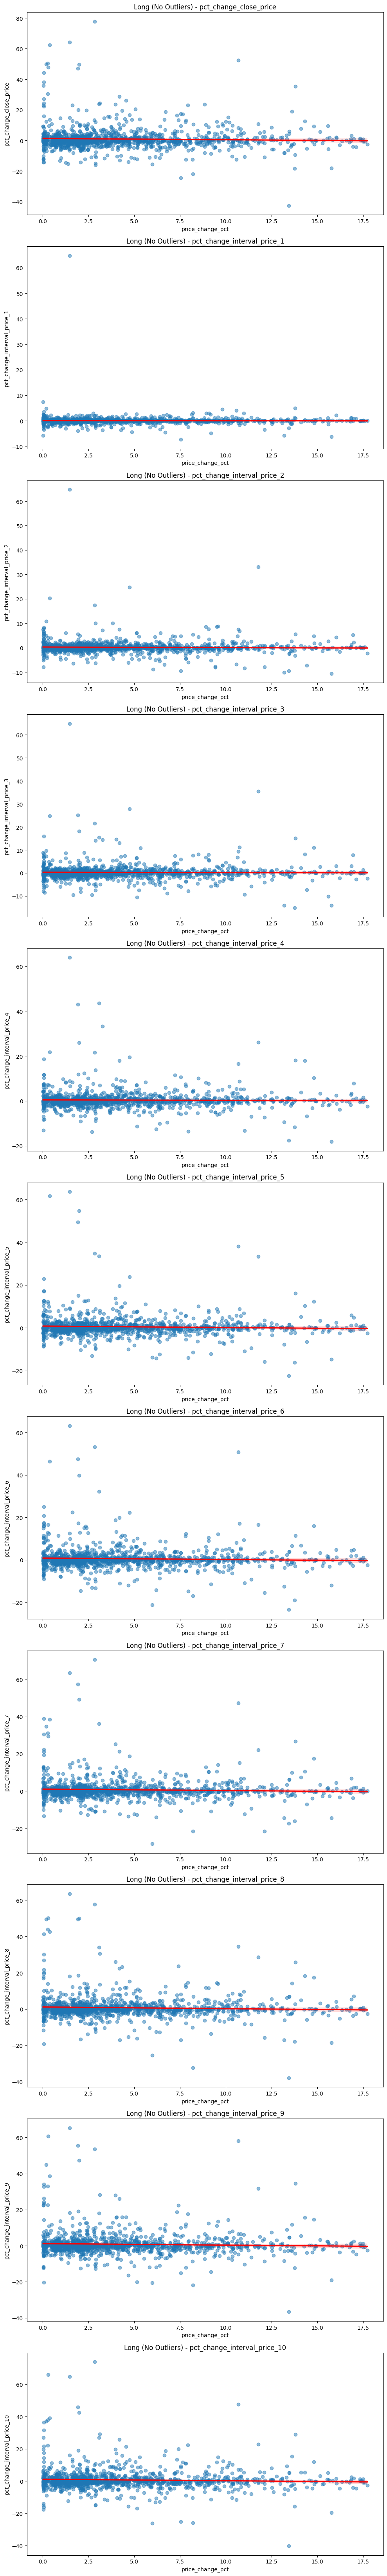

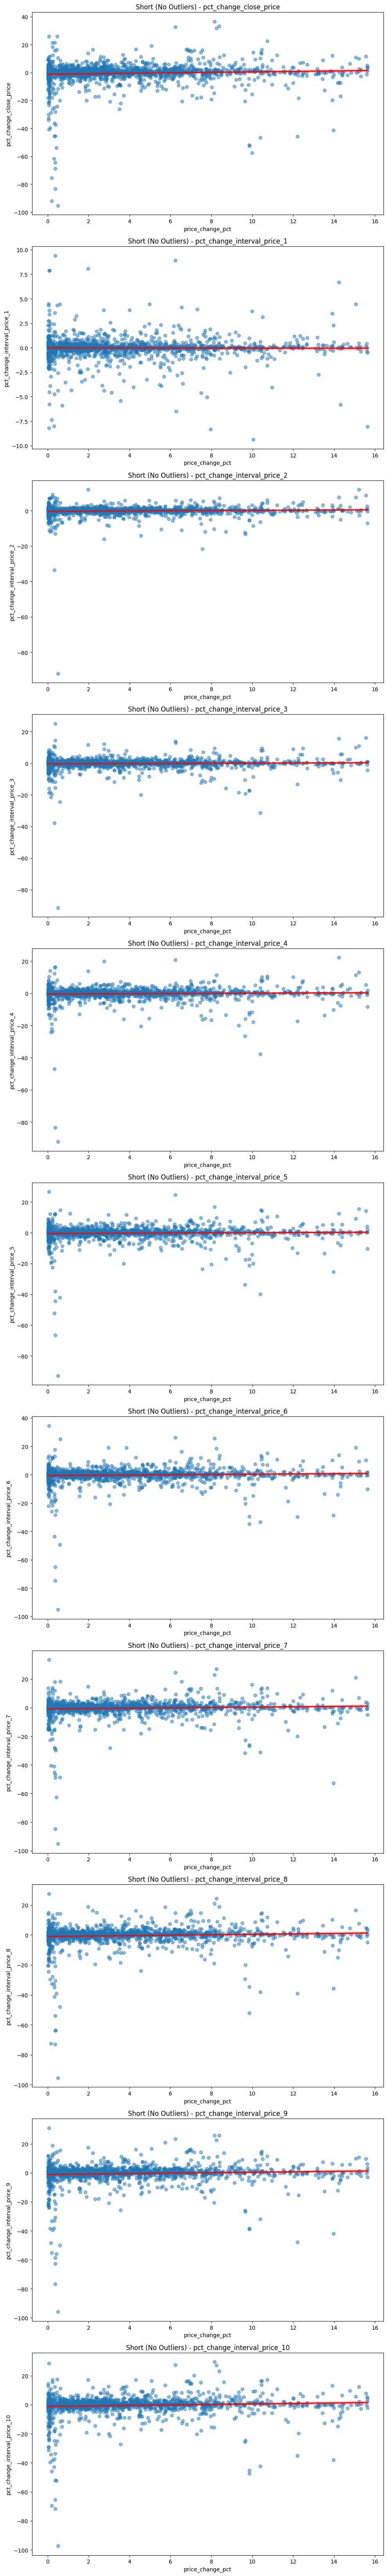

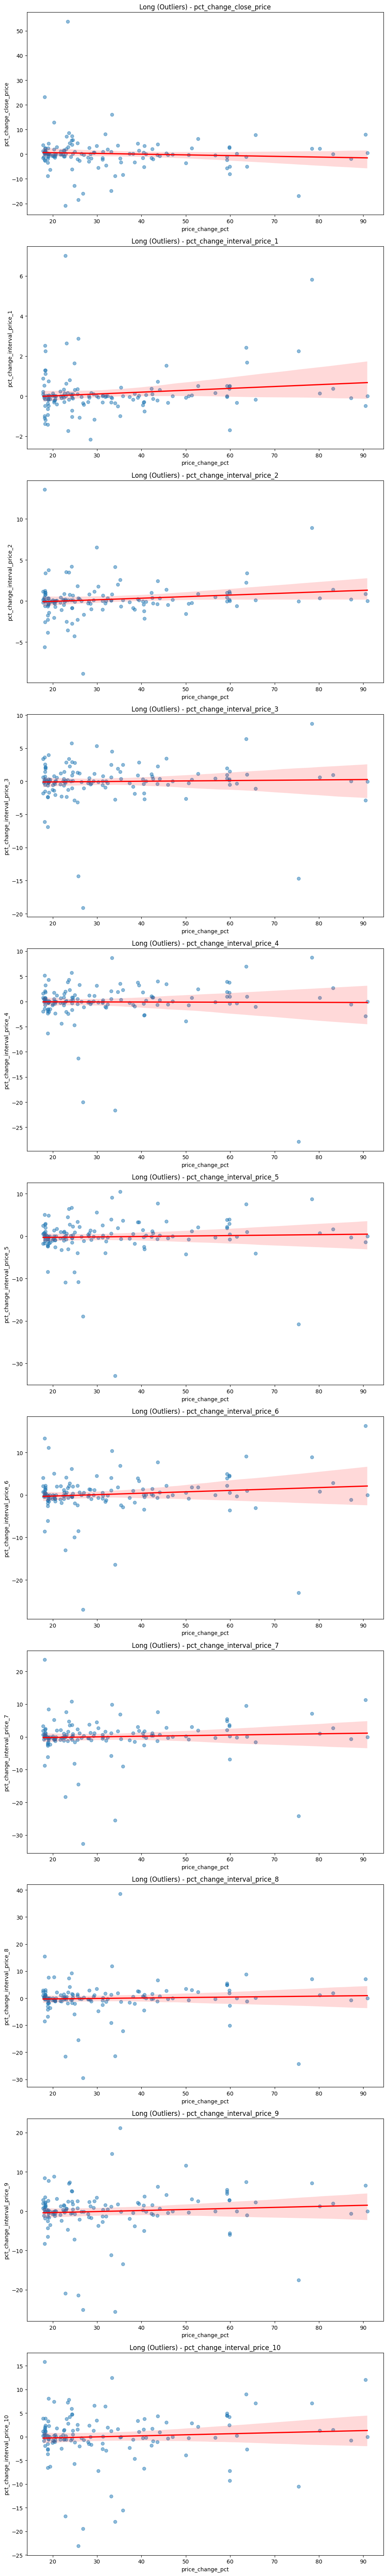

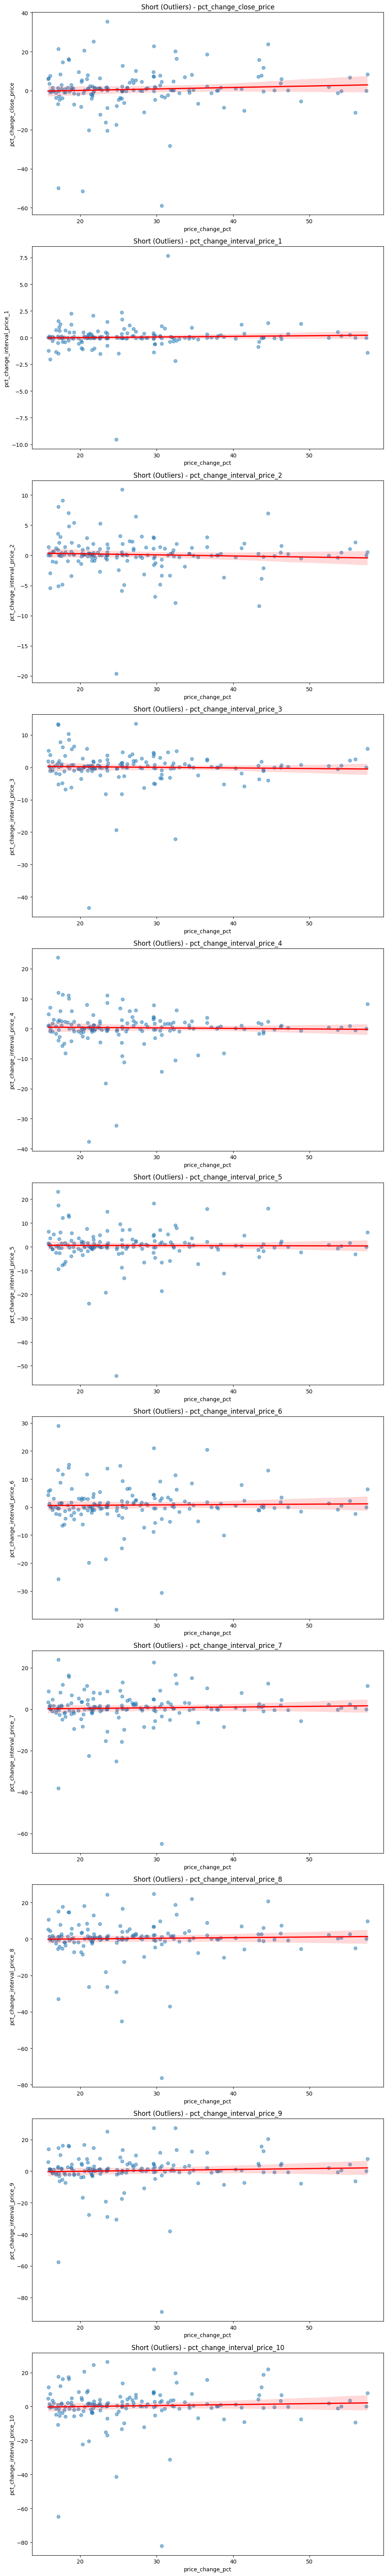

In [63]:
# Define the columns with price change parameters
price_change_columns = [
    'pct_change_close_price', 'pct_change_interval_price_1', 'pct_change_interval_price_2', 
    'pct_change_interval_price_3', 'pct_change_interval_price_4', 'pct_change_interval_price_5', 
    'pct_change_interval_price_6', 'pct_change_interval_price_7', 'pct_change_interval_price_8', 
    'pct_change_interval_price_9', 'pct_change_interval_price_10'
]

# Function to create scatter plots with correlation lines
def plot_price_change_vs_price_changes(df, position_type):
    num_columns = len(price_change_columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 6 * num_columns))  # One graph per row

    for i, column in enumerate(price_change_columns):
        sns.regplot(x=df['price_change_pct'], y=df[column], ax=axes[i], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
        axes[i].set_title(f'{position_type} - {column}')
        axes[i].set_xlabel('price_change_pct')
        axes[i].set_ylabel(f'{column}')

    plt.tight_layout()
    plt.show()

# Plotting for long and short positions with and without outliers
plot_price_change_vs_price_changes(df_long_no_outliers_price_change, "Long (No Outliers)")
plot_price_change_vs_price_changes(df_short_no_outliers_price_change, "Short (No Outliers)")
plot_price_change_vs_price_changes(outliers_long_price_change_cleaned, "Long (Outliers)")
plot_price_change_vs_price_changes(outliers_short_price_change_cleaned, "Short (Outliers)")

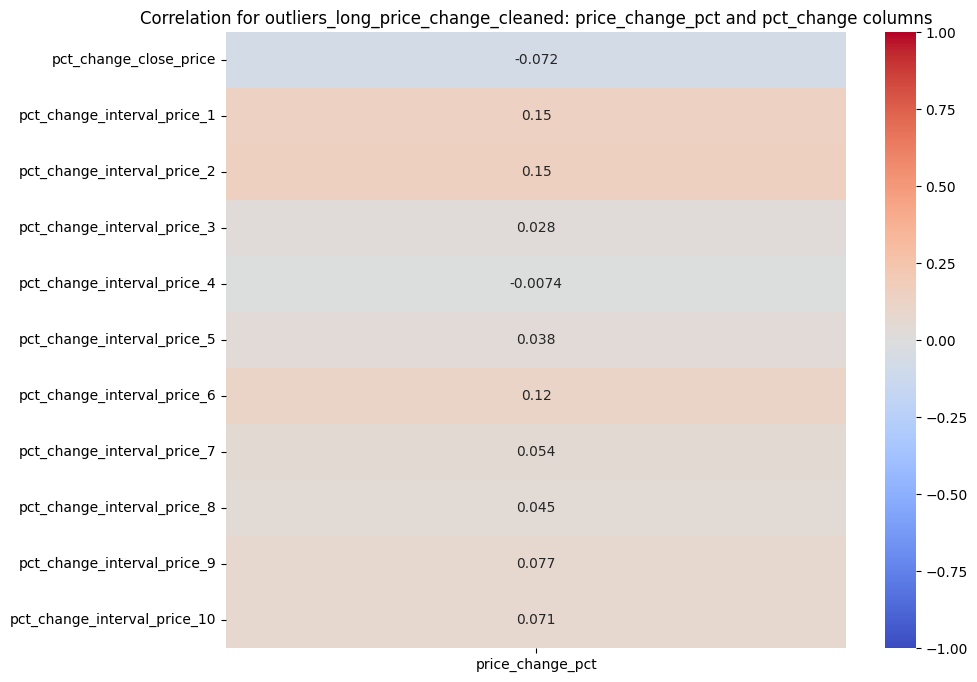

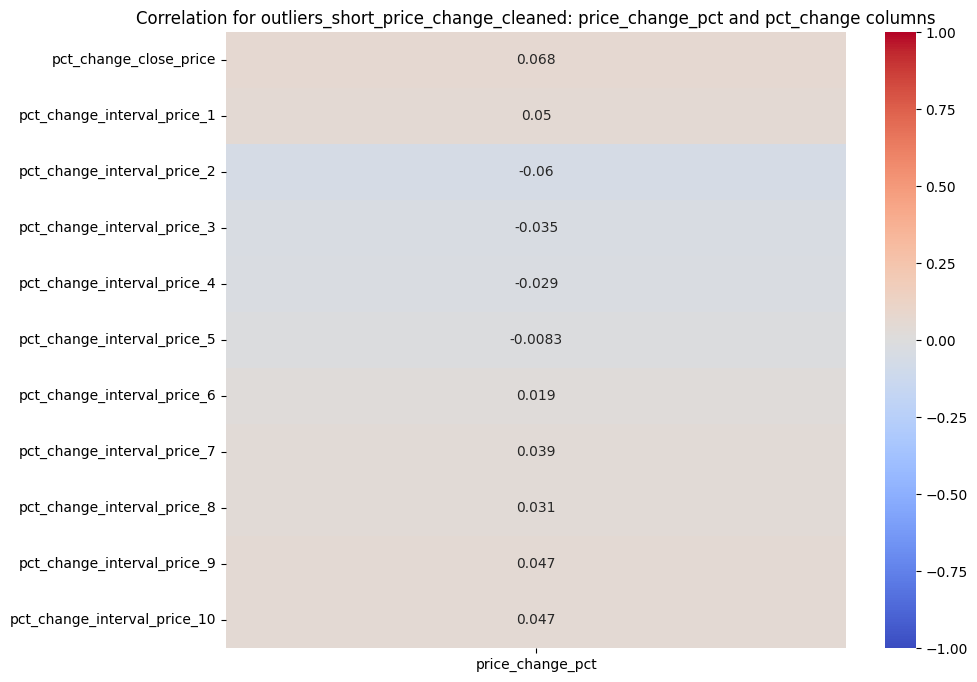

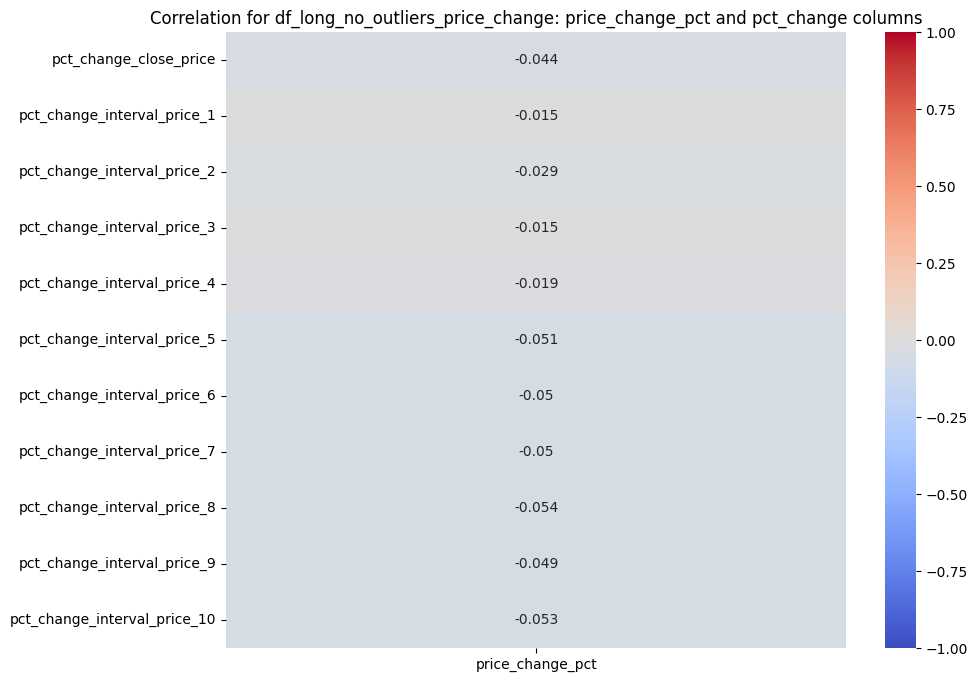

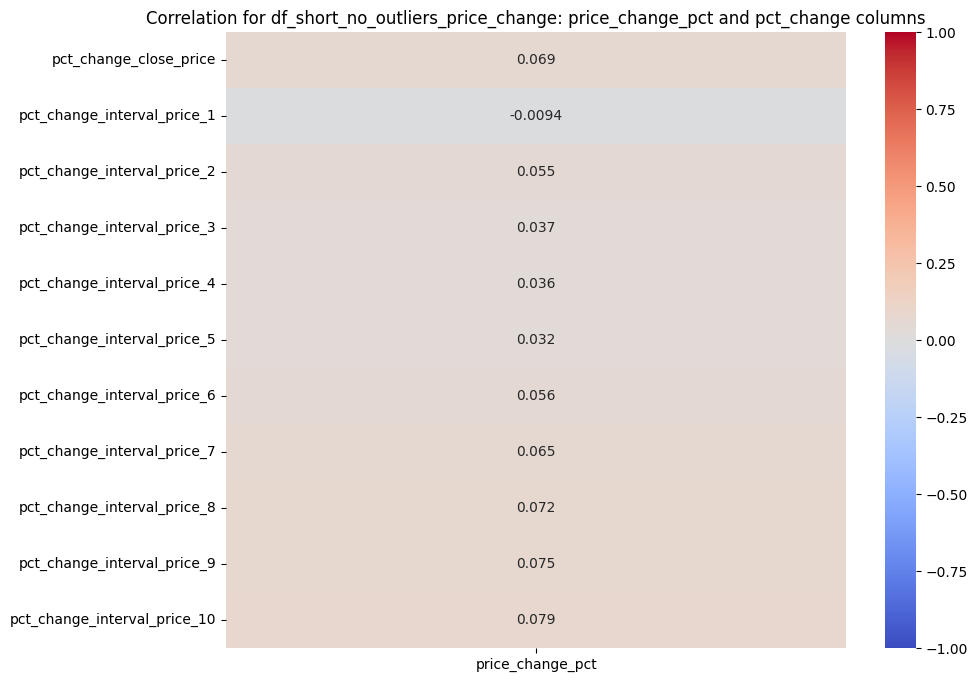

In [64]:
pct_change_columns = [
    'pct_change_close_price', 'pct_change_interval_price_1', 'pct_change_interval_price_2', 
    'pct_change_interval_price_3', 'pct_change_interval_price_4', 'pct_change_interval_price_5', 
    'pct_change_interval_price_6', 'pct_change_interval_price_7', 'pct_change_interval_price_8', 
    'pct_change_interval_price_9', 'pct_change_interval_price_10'
]

# Visualize correlation for each dataframe with appropriate dataframe names
plot_correlation_heatmap(outliers_long_price_change_cleaned, 'price_change_pct', pct_change_columns, 'outliers_long_price_change_cleaned')
plot_correlation_heatmap(outliers_short_price_change_cleaned, 'price_change_pct', pct_change_columns, 'outliers_short_price_change_cleaned')
plot_correlation_heatmap(df_long_no_outliers_price_change, 'price_change_pct', pct_change_columns, 'df_long_no_outliers_price_change')
plot_correlation_heatmap(df_short_no_outliers_price_change, 'price_change_pct', pct_change_columns, 'df_short_no_outliers_price_change')


In [65]:
# Calculate correlation and p-value for each dataframe
results_long_cleaned = calculate_correlation_and_p_value(outliers_long_price_change_cleaned, 'price_change_pct', pct_change_columns)
results_short_cleaned = calculate_correlation_and_p_value(outliers_short_price_change_cleaned, 'price_change_pct', pct_change_columns)
results_long_no_outliers = calculate_correlation_and_p_value(df_long_no_outliers_price_change, 'price_change_pct', pct_change_columns)
results_short_no_outliers = calculate_correlation_and_p_value(df_short_no_outliers_price_change, 'price_change_pct', pct_change_columns)

# Print the results
print("Results for outliers_long_price_change_cleaned:")
for column, values in results_long_cleaned.items():
    print(f"{column}: Correlation = {values['correlation']:.4f}, p-value = {values['p_value']:.4f}")
    
print("\nResults for outliers_short_price_change_cleaned:")
for column, values in results_short_cleaned.items():
    print(f"{column}: Correlation = {values['correlation']:.4f}, p-value = {values['p_value']:.4f}")
    
print("\nResults for df_long_no_outliers_price_change:")
for column, values in results_long_no_outliers.items():
    print(f"{column}: Correlation = {values['correlation']:.4f}, p-value = {values['p_value']:.4f}")
    
print("\nResults for df_short_no_outliers_price_change:")
for column, values in results_short_no_outliers.items():
    print(f"{column}: Correlation = {values['correlation']:.4f}, p-value = {values['p_value']:.4f}")

Results for outliers_long_price_change_cleaned:
pct_change_close_price: Correlation = -0.0721, p-value = 0.4004
pct_change_interval_price_1: Correlation = 0.1483, p-value = 0.0827
pct_change_interval_price_2: Correlation = 0.1509, p-value = 0.0772
pct_change_interval_price_3: Correlation = 0.0282, p-value = 0.7423
pct_change_interval_price_4: Correlation = -0.0074, p-value = 0.9317
pct_change_interval_price_5: Correlation = 0.0382, p-value = 0.6563
pct_change_interval_price_6: Correlation = 0.1169, p-value = 0.1721
pct_change_interval_price_7: Correlation = 0.0541, p-value = 0.5288
pct_change_interval_price_8: Correlation = 0.0451, p-value = 0.5990
pct_change_interval_price_9: Correlation = 0.0772, p-value = 0.3681
pct_change_interval_price_10: Correlation = 0.0711, p-value = 0.4072

Results for outliers_short_price_change_cleaned:
pct_change_close_price: Correlation = 0.0676, p-value = 0.3972
pct_change_interval_price_1: Correlation = 0.0498, p-value = 0.5333
pct_change_interval_price

In [66]:
# Display DataFrame
display(calculate_and_simulate(outliers_long_price_change_cleaned))

Interval    WinRate  Initial Capital  Final Capital
0         pct_change_close_price  52.173913             1000    1002.926080
1    pct_change_interval_price_1  42.028986             1000    1001.836432
2    pct_change_interval_price_2  52.898551             1000    1003.004882
3    pct_change_interval_price_3  52.173913             1000     999.625971
4    pct_change_interval_price_4  53.623188             1000     998.727259
5    pct_change_interval_price_5  50.000000             1000     998.099138
6    pct_change_interval_price_6  50.000000             1000    1002.332093
7    pct_change_interval_price_7  55.797101             1000    1000.928147
8    pct_change_interval_price_8  51.449275             1000     999.378142
9    pct_change_interval_price_9  52.173913             1000     999.433900
10  pct_change_interval_price_10  51.449275             1000    1000.515436

In [67]:
# Display DataFrame
display(calculate_and_simulate(outliers_short_price_change_cleaned))

Interval    WinRate  Initial Capital  Final Capital
0         pct_change_close_price  61.006289             1000    1011.247709
1    pct_change_interval_price_1  49.685535             1000    1000.716834
2    pct_change_interval_price_2  58.490566             1000    1002.023174
3    pct_change_interval_price_3  56.603774             1000    1000.371054
4    pct_change_interval_price_4  59.748428             1000    1004.964270
5    pct_change_interval_price_5  58.490566             1000    1008.925399
6    pct_change_interval_price_6  55.974843             1000    1011.273895
7    pct_change_interval_price_7  61.635220             1000    1008.652568
8    pct_change_interval_price_8  61.006289             1000    1003.445283
9    pct_change_interval_price_9  62.264151             1000    1005.426503
10  pct_change_interval_price_10  61.006289             1000    1006.412903

In [68]:
# Display DataFrame
display(calculate_and_simulate(df_long_no_outliers_price_change))

Interval    WinRate  Initial Capital  Final Capital
0         pct_change_close_price  48.895659             1000    1125.837770
1    pct_change_interval_price_1  44.325971             1000    1004.899882
2    pct_change_interval_price_2  45.925362             1000    1021.824396
3    pct_change_interval_price_3  49.124143             1000    1034.129913
4    pct_change_interval_price_4  48.591013             1000    1048.363577
5    pct_change_interval_price_5  47.448591             1000    1065.719951
6    pct_change_interval_price_6  47.829398             1000    1073.443264
7    pct_change_interval_price_7  48.819497             1000    1092.911747
8    pct_change_interval_price_8  48.895659             1000    1106.066231
9    pct_change_interval_price_9  48.667174             1000    1110.167979
10  pct_change_interval_price_10  48.286367             1000    1108.946801

In [69]:
# Display DataFrame
display(calculate_and_simulate(df_short_no_outliers_price_change))

Interval    WinRate  Initial Capital  Final Capital
0         pct_change_close_price  56.099071             1000     909.763056
1    pct_change_interval_price_1  46.687307             1000     995.819308
2    pct_change_interval_price_2  50.959752             1000     972.806783
3    pct_change_interval_price_3  50.835913             1000     965.205672
4    pct_change_interval_price_4  52.755418             1000     960.570733
5    pct_change_interval_price_5  52.755418             1000     953.360197
6    pct_change_interval_price_6  53.560372             1000     960.172596
7    pct_change_interval_price_7  54.613003             1000     941.653673
8    pct_change_interval_price_8  55.417957             1000     926.940604
9    pct_change_interval_price_9  54.427245             1000     917.330132
10  pct_change_interval_price_10  55.170279             1000     917.145991

## **Conclusion and Improvements**

### Conclusion:
The analysis conducted for the additional parameter **Price Change Percentage** yielded no new insights and showed the same results as the **trade_to_liquidity** analysis. This outcome is logical, as both price changes are influenced by the same underlying parameters. Therefore, the conclusion remains unchanged: **DCA (Dollar-Cost Averaging) strategy cannot be used for stable profits** because it is not possible to distinguish between tokens whose price change was truly impacted by the purchase and those whose price moved in the opposite direction due to other reasons. 

### Potential Improvements:
1. **Account for Closed Trades**: When collecting data, the bot should be able to recognize if the trade was closed, ensuring that the bot is no longer influencing the token's price movement after the trade has ended. This would improve the accuracy of the analysis by removing the bot's impact on future price changes.

2. **Use Data from DEX (Decentralized Exchanges)**: The data used in the analysis was sourced from MEXC, but sometimes tokens might not be listed on MEXC even though they have been traded on decentralized exchanges (DEX) for a long time. This discrepancy can lead to incorrect price changes. By using DEX data, we can ensure more accurate and timely price information for our analysis.

3. **Incorporate Token Liquidity**: Additionally, token liquidity should be factored into the analysis. Using liquidity data not from the bot, but directly from DEXs, will provide more reliable and relevant information. Liquidity directly influences price changes, and better understanding it will improve the robustness of the analysis.
